In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! rm -rf trnet-lite-tesis
! git clone https://gitlab.com/LuiggiTenorioK/trnet-lite-tesis.git

Cloning into 'trnet-lite-tesis'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 66 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [0]:
import sys
sys.path.append("./trnet-lite-tesis/")
import utils

In [0]:
import pandas as pd
import numpy as np
import pickle
import gc
import keras
from keras import backend as K

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold

# Data loading

In [0]:
infile = open('/content/drive/My Drive/Tesis2/Arq7/data/XAL.bin','rb')
xa = pickle.load(infile)
infile.close()
print(xa.shape)

infile = open('/content/drive/My Drive/Tesis2/Arq7/data/XDL.bin','rb')
xd = pickle.load(infile)
infile.close()
print(xd.shape)

(7225, 12, 12, 5)
(7225, 20, 15)


In [0]:
df_Y_total = pd.read_csv('/content/drive/My Drive/Tesis2/Arq7/data/Y.csv')
Y_cols = df_Y_total.columns
print(df_Y_total.shape)
df_Y_total.head()

(7225, 27)


pdb_code chain  class_II  ...  subclass_V_3  subclass_V_4  subclass_V_5
0     1a0r     B       0.0  ...           0.0           0.0           0.0
1     1a0t     P       0.0  ...           0.0           0.0           0.0
2     1a0t     Q       0.0  ...           0.0           0.0           0.0
3     1a12     A       0.0  ...           0.0           0.0           0.0
4     1a12     B       0.0  ...           0.0           0.0           0.0

[5 rows x 27 columns]

# Functions

In [0]:
def ravel_2d(arr):
    dims = (arr.shape[0],np.array(arr.shape[1:]).prod())
    return np.reshape(arr,dims)
  
def resample(xa_train,xd_train,y_train):
  from imblearn.over_sampling import RandomOverSampler
  ros = RandomOverSampler(random_state=20)
  xa_resampled, y_resampled = ros.fit_resample(ravel_2d(xa_train), y_train)
  xd_resampled, y_resampled2 = ros.fit_resample(ravel_2d(xd_train), y_train)
  print("Correct resample: ",(y_resampled==y_resampled2).sum()==xa_resampled.shape[0])
  
  xa_resampled=xa_resampled.reshape((xa_resampled.shape[0],xa.shape[1],xa.shape[2],xa.shape[3]))
  xd_resampled=xd_resampled.reshape((xd_resampled.shape[0],xd.shape[1],xd.shape[2]))
  print(xa_resampled.shape)
  print(xd_resampled.shape)
  
  return xa_resampled, xd_resampled, y_resampled

def plot_train_history(history):
  import matplotlib.pyplot as plt
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def filter_threshold(probabilities, threshold):
    return [1 if f >= threshold else 0 for f in probabilities]
  
def get_threshold_measures_df(observed, probabilities):
    import sklearn
    steps = [x / 100.0 for x in range(5, 101, 5)]
    df = pd.DataFrame(columns=['Punto de corte','Accuracy',  'Recall', 'Precision','AUC', 'F1', 'F0.5'])

    print("AUC:",sklearn.metrics.roc_auc_score(observed, probabilities))

    for i in range(len(steps)):
        estimated_threshold = filter_threshold(probabilities, steps[i])
        row = [
            steps[i],
            sklearn.metrics.accuracy_score(observed, estimated_threshold),
            sklearn.metrics.recall_score(observed, estimated_threshold),
            sklearn.metrics.precision_score(observed, estimated_threshold),
            sklearn.metrics.roc_auc_score(observed, estimated_threshold),
            sklearn.metrics.f1_score(observed,estimated_threshold),
            sklearn.metrics.fbeta_score(observed,estimated_threshold, beta=0.5)
        ]
        df.loc[i] = row

    return df

In [0]:
to_train_cols = ['subclass_III_3', 'subclass_IV_1','subclass_IV_2','subclass_IV_4']

# Cross validation

Start split###########################################################
(4624, 12, 12, 5) (1156, 12, 12, 5) (1445, 12, 12, 5)
(4624, 20, 15) (1156, 20, 15) (1445, 20, 15)
(4624,) (1156,) (1445,)
Counter({0.0: 3769, 1.0: 855}) Counter({0.0: 942, 1.0: 214}) Counter({0.0: 1178, 1.0: 267})
Correct resample:  True
(7538, 12, 12, 5)
(7538, 20, 15)
Correct resample:  True
(1884, 12, 12, 5)
(1884, 20, 15)
Training Arq7xal model----------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 7538 samples, validate on 1884 samples
Epoch 1/80
 - 1s - loss: 0.5976 - accuracy: 0.6007 - val_loss: 0.5703 - val_accuracy: 0.6417
Epoch 2/80
 - 1s - loss: 0.5342 - accuracy: 0.7494 - val_loss: 0.5188 - val_accuracy: 0.8148
Epoch 3/80
 - 1s - loss: 0.4865 - accuracy: 0.8051 - val_loss: 0.4723 - val_accuracy: 0.8296
Epoch 4/80
 - 1s - loss: 0.4428 - accuracy: 0.8248 - val_loss: 0.4284 - val_accuracy: 0.8190
Epoch 5/80
 - 1s - loss: 0.4035 - accuracy: 0.8332 - val_loss: 0.3925 - val_accuracy: 0.8264
Epoch 6/80
 - 1s - loss: 0.3678 - accuracy: 0.8405 - val_loss: 0.3615 - val_accuracy: 0.8370
Epoch 7/80
 - 1s - loss: 0.3414 - accuracy: 0.8534 - val_loss: 0.3366 - val_accuracy: 0.8471
Epoch 8/80
 - 1s - loss: 0.3143 - accuracy: 0.8665 - val_loss: 0.3127 - val_accuracy: 0.8646
Epoch 9/80
 - 1s - loss: 0.2974 - accuracy: 0.8787 - val_loss: 0.2928 - val_accuracy: 0.8822
Epoch 10/80
 - 1s - loss: 0.2755 - accuracy: 0.8908 - val_loss: 0.2723 - val_accuracy: 0.9050
Epoch 11/80
 - 1s - l

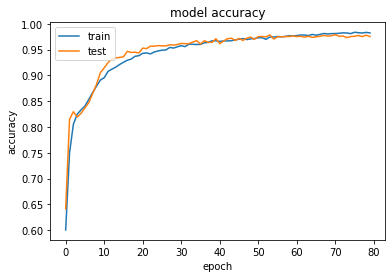

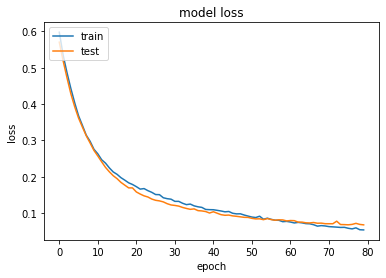

1445/1445 [==============================] - 0s 78us/step
[0.07057229048962411, 0.9785467386245728]
AUC: 0.994706319986265
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.923183  0.992509   0.708556  0.949990  0.826833  0.751560
1             0.10  0.943253  0.988764   0.769679  0.960851  0.865574  0.805369
2             0.15  0.956401  0.981273   0.818750  0.966019  0.892675  0.846800
3             0.20  0.959170  0.977528   0.831210  0.966268  0.898451  0.856861
4             0.25  0.966090  0.977528   0.858553  0.970513  0.914186  0.879973
5             0.30  0.969550  0.973783   0.875421  0.971187  0.921986  0.893471
6             0.35  0.972318  0.973783   0.887372  0.972885  0.928571  0.903405
7             0.40  0.975087  0.973783   0.899654  0.974582  0.935252  0.913563
8             0.45  0.976471  0.970037   0.908772  0.973983  0.938406  0.920398
9             0.50  0.978547  0.962547   0.924460  0.972360  0.943119  0.9318

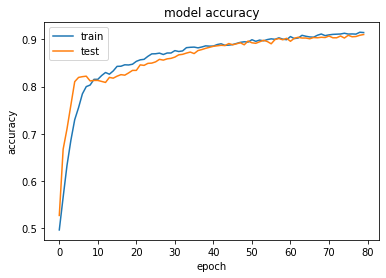

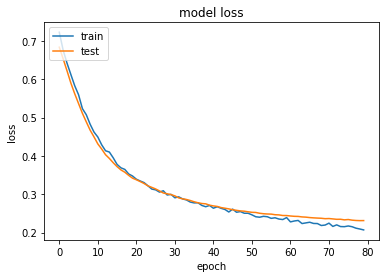

1445/1445 [==============================] - 0s 73us/step
[0.20441874992682446, 0.9065743684768677]
AUC: 0.9670202145450615


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.734948  0.981273   0.409375  0.830195  0.577729  0.463389
1             0.10  0.788235  0.970037   0.464991  0.858533  0.628641  0.519038
2             0.15  0.829066  0.962547   0.520243  0.880679  0.675427  0.572893
3             0.20  0.848443  0.951311   0.552174  0.888219  0.698762  0.602753
4             0.25  0.864360  0.932584   0.583138  0.890740  0.717579  0.630380
5             0.30  0.876817  0.928839   0.609337  0.896932  0.735905  0.654354
6             0.35  0.884429  0.921348   0.627551  0.898705  0.746586  0.670300
7             0.40  0.891349  0.898876   0.648649  0.894260  0.753532  0.686892
8             0.45  0.898962  0.887640   0.671388  0.894584  0.764516  0.705777
9             0.50  0.906574  0.883895   0.694118  0.897805  0.777595  0.725261
10            0.55  0.920415  0.876404   0.740506  0.903397  0.802744  0.764206
11            0.60  0.926644  0.868914  

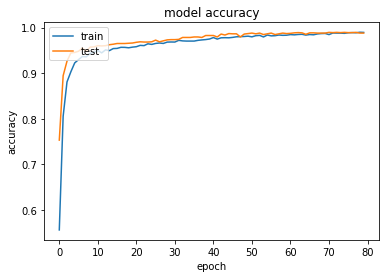

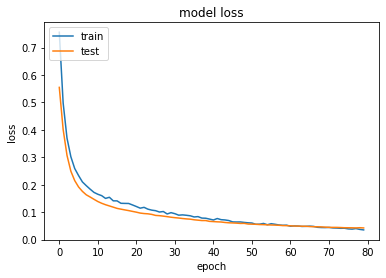

1445/1445 [==============================] - 0s 106us/step
[0.05009724565968562, 0.979238748550415]
AUC: 0.9985374817980072
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.946713  0.996255   0.777778  0.965869  0.873563  0.813456
1             0.10  0.960554  0.996255   0.826087  0.974358  0.903226  0.855305
2             0.15  0.968166  0.996255   0.855305  0.979027  0.920415  0.880212
3             0.20  0.970242  0.996255   0.863636  0.980301  0.925217  0.887258
4             0.25  0.973010  0.996255   0.875000  0.981998  0.931699  0.896831
5             0.30  0.973702  0.996255   0.877888  0.982423  0.933333  0.899256
6             0.35  0.976471  0.996255   0.889632  0.984121  0.939929  0.909091
7             0.40  0.979239  0.996255   0.901695  0.985818  0.946619  0.919143
8             0.45  0.979931  0.992509   0.907534  0.984795  0.948122  0.923345
9             0.50  0.979239  0.988764   0.907216  0.982922  0.946237  0.922

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 7538 samples, validate on 1884 samples
Epoch 1/80
 - 1s - loss: 0.5664 - accuracy: 0.7238 - val_loss: 0.5766 - val_accuracy: 0.7298
Epoch 2/80
 - 1s - loss: 0.5093 - accuracy: 0.8029 - val_loss: 0.5044 - val_accuracy: 0.8052
Epoch 3/80
 - 1s - loss: 0.4638 - accuracy: 0.8209 - val_loss: 0.4603 - val_accuracy: 0.8126
Epoch 4/80
 - 1s - loss: 0.4261 - accuracy: 0.8340 - val_loss: 0.4267 - val_accuracy: 0.8238
Epoch 5/80
 - 1s - loss: 0.3920 - accuracy: 0.8452 - val_loss: 0.3995 - val_accuracy: 0.8370
Epoch 6/80
 - 1s - loss: 0.3648 - accuracy: 0.8535 - val_loss: 0.3767 - val_accuracy: 0.8381
Epoch 7/80
 - 1s - loss: 0.3422 - accuracy: 0.8606 - val_loss: 0.3572 - val_accuracy: 0.8434
Epoch 8/80
 - 1s - loss: 0.3266 - accuracy: 0.8692 - val_loss: 0.3424 - val_accuracy: 0.8429
Epoch 9/80
 - 1s - loss: 0.3044 - accuracy: 0.8766 - val_loss: 0.3271 - val_accuracy: 0.8546
Epoch 10/80
 - 1s - loss: 0.2865 - accuracy: 0.8856 - val_loss: 0.3125 - val_accuracy: 0.8583
Epoch 11/80
 - 1s - l

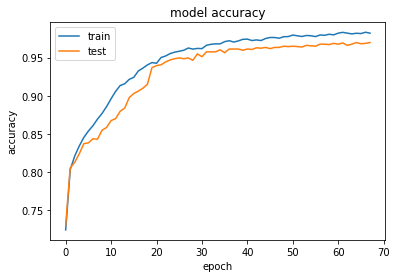

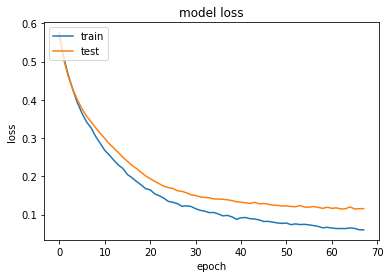

1445/1445 [==============================] - 0s 78us/step
[0.11019179089877845, 0.9674740433692932]
AUC: 0.987409625913279
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.905882  0.985019   0.665823  0.936482  0.794562  0.711965
1             0.10  0.925952  0.981273   0.719780  0.947343  0.830428  0.760302
2             0.15  0.939100  0.973783   0.762463  0.952511  0.855263  0.797057
3             0.20  0.948789  0.973783   0.795107  0.958453  0.875421  0.825397
4             0.25  0.954325  0.970037   0.817035  0.960401  0.886986  0.843648
5             0.30  0.957093  0.970037   0.827476  0.962099  0.893103  0.852535
6             0.35  0.961246  0.970037   0.843648  0.964645  0.902439  0.866221
7             0.40  0.962630  0.966292   0.851485  0.964046  0.905263  0.872211
8             0.45  0.965398  0.966292   0.862876  0.965744  0.911661  0.881750
9             0.50  0.967474  0.966292   0.871622  0.967017  0.916519  0.8890

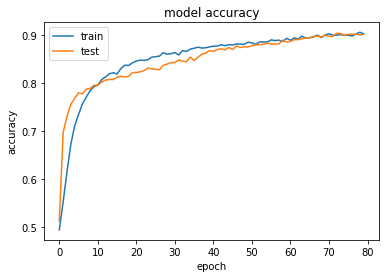

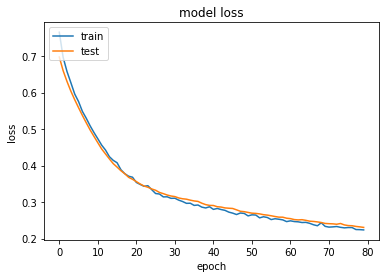

1445/1445 [==============================] - 0s 73us/step
[0.21852825067447543, 0.9065743684768677]
AUC: 0.9747175114298976


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.654671  0.996255   0.348168  0.786752  0.516004  0.400241
1             0.10  0.739792  0.996255   0.414977  0.838959  0.585903  0.469799
2             0.15  0.780623  0.988764   0.456747  0.861105  0.624852  0.511826
3             0.20  0.803460  0.981273   0.484288  0.872216  0.648515  0.538873
4             0.25  0.839446  0.970037   0.536232  0.889942  0.690667  0.588904
5             0.30  0.857439  0.966292   0.567033  0.899530  0.714681  0.618112
6             0.35  0.867128  0.955056   0.586207  0.901127  0.726496  0.635277
7             0.40  0.877509  0.951311   0.607656  0.906046  0.741606  0.654977
8             0.45  0.892734  0.943820   0.642857  0.912487  0.764795  0.686649
9             0.50  0.906574  0.940075   0.678378  0.919528  0.788069  0.718374
10            0.55  0.912803  0.928839   0.698592  0.919004  0.797428  0.735033
11            0.60  0.919031  0.902622  

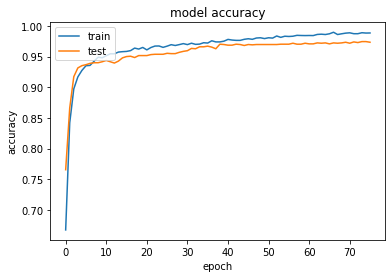

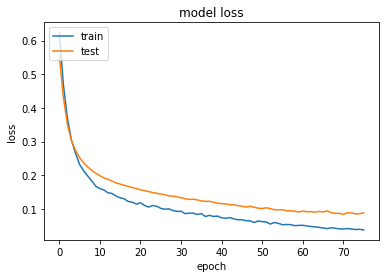

1445/1445 [==============================] - 0s 114us/step
[0.07401722003560784, 0.970934271812439]
AUC: 0.9963564220446005
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.923183  0.992509   0.708556  0.949990  0.826833  0.751560
1             0.10  0.945329  0.992509   0.774854  0.963572  0.870279  0.810398
2             0.15  0.952941  0.988764   0.802432  0.966793  0.885906  0.833860
3             0.20  0.957785  0.988764   0.819876  0.969764  0.896435  0.848875
4             0.25  0.960554  0.988764   0.830189  0.971462  0.902564  0.857700
5             0.30  0.963322  0.988764   0.840764  0.973160  0.908778  0.866710
6             0.35  0.965398  0.981273   0.853420  0.971537  0.912892  0.876254
7             0.40  0.967474  0.981273   0.861842  0.972810  0.917688  0.883345
8             0.45  0.968858  0.973783   0.872483  0.970762  0.920354  0.891021
9             0.50  0.970934  0.970037   0.883959  0.970587  0.925000  0.899

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 7538 samples, validate on 1884 samples
Epoch 1/80
 - 1s - loss: 0.7477 - accuracy: 0.6045 - val_loss: 0.5768 - val_accuracy: 0.7702
Epoch 2/80
 - 1s - loss: 0.5607 - accuracy: 0.7608 - val_loss: 0.4976 - val_accuracy: 0.8073
Epoch 3/80
 - 1s - loss: 0.4960 - accuracy: 0.8053 - val_loss: 0.4500 - val_accuracy: 0.8339
Epoch 4/80
 - 1s - loss: 0.4506 - accuracy: 0.8265 - val_loss: 0.4106 - val_accuracy: 0.8471
Epoch 5/80
 - 1s - loss: 0.4171 - accuracy: 0.8368 - val_loss: 0.3739 - val_accuracy: 0.8700
Epoch 6/80
 - 1s - loss: 0.3867 - accuracy: 0.8412 - val_loss: 0.3432 - val_accuracy: 0.8790
Epoch 7/80
 - 1s - loss: 0.3624 - accuracy: 0.8505 - val_loss: 0.3154 - val_accuracy: 0.8923
Epoch 8/80
 - 1s - loss: 0.3375 - accuracy: 0.8619 - val_loss: 0.2915 - val_accuracy: 0.8970
Epoch 9/80
 - 1s - loss: 0.3118 - accuracy: 0.8729 - val_loss: 0.2719 - val_accuracy: 0.9045
Epoch 10/80
 - 1s - loss: 0.2990 - accuracy: 0.8768 - val_loss: 0.2531 - val_accuracy: 0.9183
Epoch 11/80
 - 1s - l

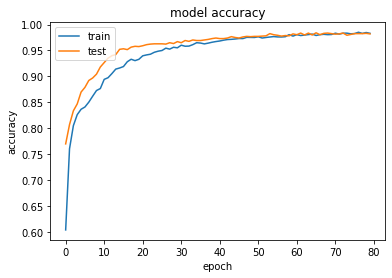

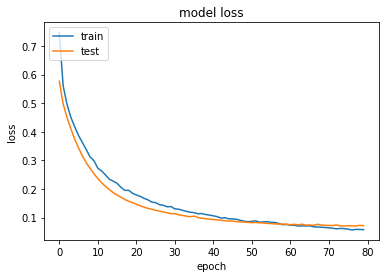

1445/1445 [==============================] - 0s 72us/step
[0.07578293282577324, 0.9806228280067444]
AUC: 0.9895334566935643


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.935640  0.973783   0.751445  0.950389  0.848287  0.787402
1             0.10  0.957093  0.970037   0.827476  0.962099  0.893103  0.852535
2             0.15  0.964014  0.970037   0.854785  0.966343  0.908772  0.875592
3             0.20  0.967474  0.970037   0.869128  0.968465  0.916814  0.887594
4             0.25  0.970242  0.970037   0.880952  0.970163  0.923351  0.897436
5             0.30  0.976471  0.970037   0.908772  0.973983  0.938406  0.920398
6             0.35  0.978547  0.970037   0.918440  0.975256  0.943534  0.928315
7             0.40  0.977163  0.962547   0.917857  0.971511  0.939671  0.926460
8             0.45  0.979931  0.962547   0.931159  0.973209  0.946593  0.937272
9             0.50  0.980623  0.958801   0.937729  0.972185  0.948148  0.941869
10            0.55  0.981315  0.955056   0.944444  0.971161  0.949721  0.946548
11            0.60  0.981315  0.955056  

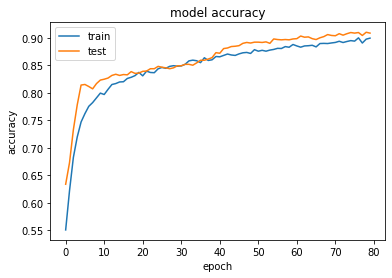

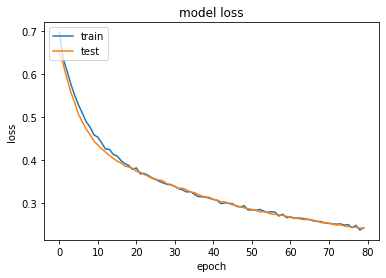

1445/1445 [==============================] - 0s 70us/step
[0.25258663698876194, 0.8705882430076599]
AUC: 0.9627089652365781


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.652595  0.988764   0.346003  0.782582  0.512621  0.397710
1             0.10  0.722491  0.988764   0.398792  0.825452  0.568353  0.452830
2             0.15  0.772318  0.977528   0.446918  0.851667  0.613396  0.501345
3             0.20  0.793772  0.966292   0.471664  0.860481  0.633907  0.525458
4             0.25  0.811765  0.958801   0.495164  0.868620  0.653061  0.548180
5             0.30  0.827682  0.951311   0.518367  0.875486  0.671070  0.570274
6             0.35  0.837370  0.932584   0.534335  0.874187  0.679400  0.584233
7             0.40  0.847059  0.921348   0.551570  0.875785  0.690042  0.599707
8             0.45  0.850519  0.902622   0.559165  0.870666  0.690544  0.605224
9             0.50  0.870588  0.895131   0.600503  0.880078  0.718797  0.642819
10            0.55  0.891349  0.895131   0.649457  0.892812  0.752756  0.687177
11            0.60  0.897578  0.872659  

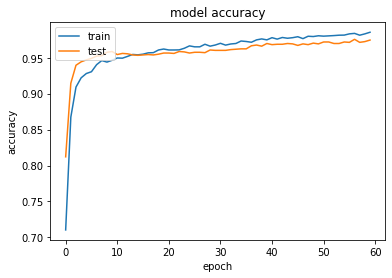

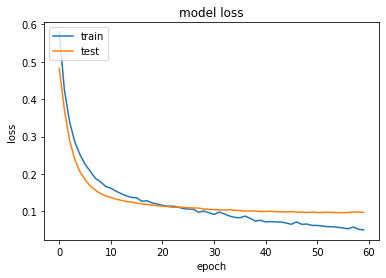

1445/1445 [==============================] - 0s 102us/step
[0.06883054978913501, 0.979238748550415]
AUC: 0.9956315217183952


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.938408  0.985019   0.755747  0.956431  0.855285  0.792646
1             0.10  0.952941  0.985019   0.804281  0.965345  0.885522  0.834921
2             0.15  0.961246  0.985019   0.834921  0.970438  0.903780  0.861166
3             0.20  0.964014  0.981273   0.847896  0.970688  0.909722  0.871590
4             0.25  0.969550  0.981273   0.870432  0.974083  0.922535  0.890551
5             0.30  0.973702  0.981273   0.888136  0.976630  0.932384  0.905321
6             0.35  0.975087  0.977528   0.896907  0.976031  0.935484  0.911950
7             0.40  0.977163  0.977528   0.906250  0.977304  0.940541  0.919662
8             0.45  0.979239  0.977528   0.915789  0.978577  0.945652  0.927505
9             0.50  0.979239  0.973783   0.918728  0.977129  0.945455  0.929235
10            0.55  0.980623  0.973783   0.925267  0.977978  0.948905  0.934579
11            0.60  0.980623  0.973783  

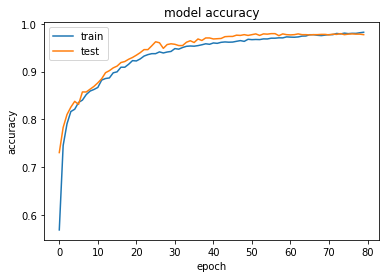

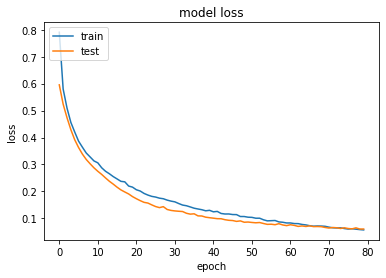

1445/1445 [==============================] - 0s 72us/step
[0.0736572873884986, 0.979238748550415]
AUC: 0.9969128148388368
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.910727  1.000000   0.674242  0.945246  0.805430  0.721232
1             0.10  0.934256  0.996255   0.738889  0.958229  0.848485  0.779145
2             0.15  0.948789  0.996255   0.784661  0.967143  0.877888  0.819470
3             0.20  0.953633  0.996255   0.801205  0.970114  0.888147  0.833856
4             0.25  0.962630  0.996255   0.833856  0.975632  0.907850  0.861957
5             0.30  0.967474  0.996255   0.852564  0.978603  0.918826  0.877888
6             0.35  0.972318  0.996255   0.872131  0.981574  0.930070  0.894418
7             0.40  0.974394  0.996255   0.880795  0.982847  0.934974  0.901695
8             0.45  0.977163  0.992509   0.895270  0.983097  0.941385  0.913163
9             0.50  0.979239  0.992509   0.904437  0.984370  0.946429  0.92077

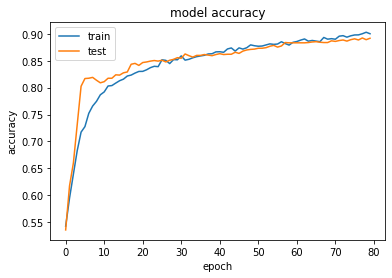

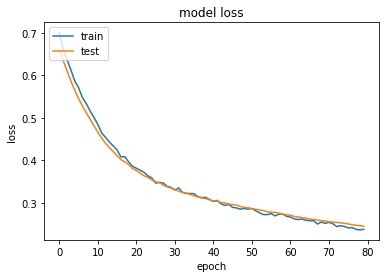

1445/1445 [==============================] - 0s 79us/step
[0.2587095001989582, 0.8892733454704285]
AUC: 0.9637327279779732


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.612457  0.988764   0.321559  0.757964  0.485294  0.371726
1             0.10  0.687889  0.985019   0.370423  0.802781  0.538383  0.423238
2             0.15  0.742561  0.985019   0.416799  0.836312  0.585746  0.471157
3             0.20  0.778547  0.985019   0.454231  0.858384  0.621749  0.509098
4             0.25  0.811073  0.970037   0.494275  0.872540  0.654867  0.548032
5             0.30  0.838754  0.970037   0.535124  0.889518  0.689747  0.587835
6             0.35  0.851211  0.955056   0.556769  0.891365  0.703448  0.607432
7             0.40  0.864360  0.951311   0.581236  0.897981  0.721591  0.630273
8             0.45  0.877509  0.943820   0.608696  0.903150  0.740088  0.655226
9             0.50  0.889273  0.921348   0.638961  0.901676  0.754601  0.680686
10            0.55  0.895502  0.902622   0.658470  0.898255  0.761453  0.696129
11            0.60  0.902422  0.887640  

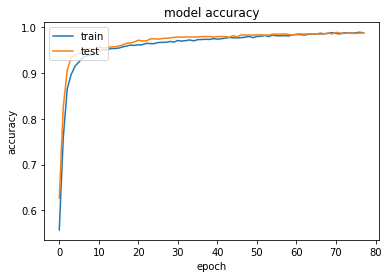

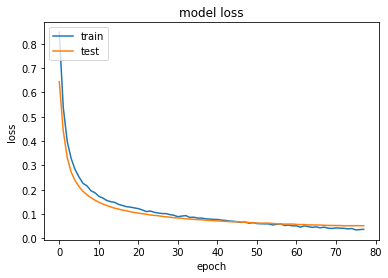

1445/1445 [==============================] - 0s 99us/step
[0.08284654138564651, 0.9813148975372314]
AUC: 0.9928749928463784
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.936332  0.992509   0.746479  0.958054  0.852090  0.785418
1             0.10  0.952941  0.988764   0.802432  0.966793  0.885906  0.833860
2             0.15  0.959862  0.988764   0.827586  0.971037  0.901024  0.855476
3             0.20  0.966090  0.988764   0.851613  0.974857  0.915078  0.875912
4             0.25  0.968858  0.988764   0.862745  0.976555  0.921466  0.885312
5             0.30  0.973702  0.988764   0.882943  0.979526  0.932862  0.902256
6             0.35  0.977855  0.988764   0.901024  0.982073  0.942857  0.917304
7             0.40  0.979239  0.988764   0.907216  0.982922  0.946237  0.922432
8             0.45  0.980623  0.988764   0.913495  0.983771  0.949640  0.927618
9             0.50  0.981315  0.988764   0.916667  0.984195  0.951351  0.930

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Train on 7540 samples, validate on 1884 samples
Epoch 1/80
 - 1s - loss: 0.6270 - accuracy: 0.5195 - val_loss: 0.5816 - val_accuracy: 0.5053
Epoch 2/80
 - 1s - loss: 0.5548 - accuracy: 0.7192 - val_loss: 0.5233 - val_accuracy: 0.7818
Epoch 3/80
 - 1s - loss: 0.5026 - accuracy: 0.8081 - val_loss: 0.4623 - val_accuracy: 0.8243
Epoch 4/80
 - 1s - loss: 0.4505 - accuracy: 0.8401 - val_loss: 0.4106 - val_accuracy: 0.8652
Epoch 5/80
 - 1s - loss: 0.4152 - accuracy: 0.8521 - val_loss: 0.3683 - val_accuracy: 0.8753
Epoch 6/80
 - 1s - loss: 0.3760 - accuracy: 0.8639 - val_loss: 0.3319 - val_accuracy: 0.8901
Epoch 7/80
 - 1s - loss: 0.3505 - accuracy: 0.8698 - val_loss: 0.3051 - val_accuracy: 0.8949
Epoch 8/80
 - 1s - loss: 0.3255 - accuracy: 0.8849 - val_loss: 0.2830 - val_accuracy: 0.9029
Epoch 9/80
 - 1s - loss: 0.3041 - accuracy: 0.8898 - val_loss: 0.2636 - val_accuracy: 0.9114
Epoch 10/80
 - 1s - loss: 0.2833 - accuracy: 0.8979 - val_loss: 0.2479 - val_accuracy: 0.9172
Epoch 11/80
 - 1s - l

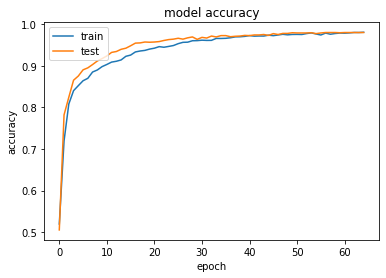

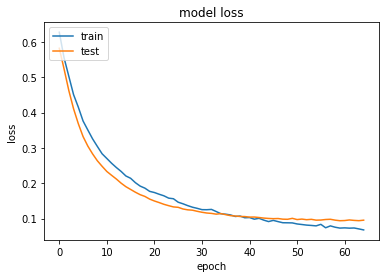

1445/1445 [==============================] - 0s 69us/step
[0.09388050655077072, 0.9695501923561096]
AUC: 0.9931681862564831


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.907958  0.996269   0.669173  0.942060  0.800600  0.716202
1             0.10  0.934256  0.988806   0.742297  0.955321  0.848000  0.781250
2             0.15  0.948097  0.985075   0.788060  0.962376  0.875622  0.820896
3             0.20  0.950865  0.985075   0.797583  0.964075  0.881469  0.829146
4             0.25  0.955709  0.981343   0.816770  0.965608  0.891525  0.845116
5             0.30  0.958478  0.981343   0.827044  0.967307  0.897611  0.853896
6             0.35  0.964014  0.981343   0.848387  0.970706  0.910035  0.872016
7             0.40  0.966090  0.977612   0.859016  0.970539  0.914485  0.880376
8             0.45  0.967474  0.977612   0.864686  0.971389  0.917688  0.885135
9             0.50  0.969550  0.973881   0.875839  0.971222  0.922261  0.893836
10            0.55  0.972318  0.970149   0.890411  0.971481  0.928571  0.905292
11            0.60  0.970242  0.955224  

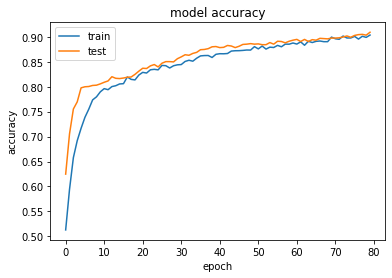

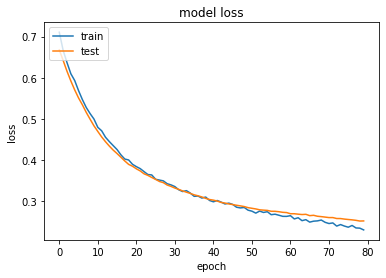

1445/1445 [==============================] - 0s 68us/step
[0.2507188461643602, 0.8982698917388916]
AUC: 0.9566124348520777


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.660208  0.985075   0.351531  0.785655  0.518155  0.403423
1             0.10  0.715571  0.977612   0.392804  0.816758  0.560428  0.446185
2             0.15  0.758478  0.966418   0.432387  0.838774  0.597463  0.486111
3             0.20  0.786851  0.955224   0.463768  0.851869  0.624390  0.516963
4             0.25  0.818685  0.944030   0.506000  0.867087  0.658854  0.557760
5             0.30  0.842215  0.944030   0.542918  0.881531  0.689373  0.593340
6             0.35  0.856747  0.932836   0.569476  0.886129  0.707214  0.617589
7             0.40  0.875433  0.929104   0.607317  0.896158  0.734513  0.652516
8             0.45  0.885813  0.917910   0.632391  0.898208  0.748858  0.674342
9             0.50  0.898270  0.902985   0.666667  0.900091  0.767036  0.703488
10            0.55  0.903114  0.869403   0.689349  0.890097  0.768977  0.719136
11            0.60  0.905882  0.817164  

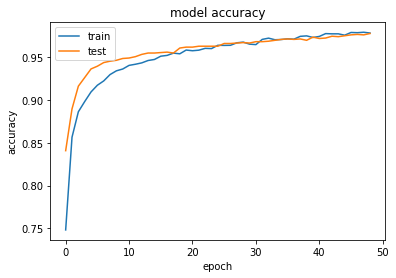

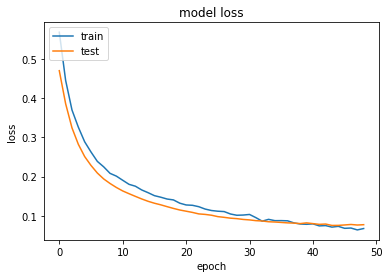

1445/1445 [==============================] - 0s 116us/step
[0.09305530861793505, 0.9674740433692932]
AUC: 0.9957867840068984
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.919723  1.000000   0.697917  0.950722  0.822086  0.742794
1             0.10  0.939792  1.000000   0.754930  0.963042  0.860353  0.793839
2             0.15  0.947405  1.000000   0.779070  0.967715  0.875817  0.815085
3             0.20  0.952249  0.996269   0.797015  0.969247  0.885572  0.830224
4             0.25  0.955709  0.996269   0.809091  0.971371  0.892977  0.840680
5             0.30  0.958478  0.996269   0.819018  0.973071  0.898990  0.849237
6             0.35  0.961938  0.996269   0.831776  0.975195  0.906621  0.860180
7             0.40  0.964014  0.996269   0.839623  0.976469  0.911263  0.866883
8             0.45  0.966090  0.996269   0.847619  0.977744  0.915952  0.873691
9             0.50  0.967474  0.996269   0.853035  0.978593  0.919105  0.87

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
selected_class = 'subclass_III_3'
y = df_Y_total[selected_class]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
for train_index, test_index in skf.split(np.zeros(y.shape[0]), y):
  print('Start split###########################################################')
  xa_train, xa_test, xd_train, xd_test, y_train, y_test = xa[train_index], xa[test_index], xd[train_index], xd[test_index], y[train_index], y[test_index]

  xa_train, xa_val, xd_train, xd_val, y_train, y_val = train_test_split(xa_train, xd_train, y_train, random_state=10, 
                                                                           test_size=0.2, stratify=y_train)
  from collections import Counter
  print(xa_train.shape, xa_val.shape, xa_test.shape)
  print(xd_train.shape, xd_val.shape, xd_test.shape)
  print(y_train.shape, y_val.shape, y_test.shape)
  print(Counter(y_train), Counter(y_val), Counter(y_test))

  xa_train_resampled, xd_train_resampled, y_train_resampled = resample(xa_train, xd_train, y_train)
  xa_val_resampled, xd_val_resampled, y_val_resampled = resample(xa_val, xd_val, y_val)

  from utils import modeler
  from keras.callbacks import EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  num_epochs = 80
  batch_size = 64

  # Arq7xal
  print('Training Arq7xal model----------------------------------------------------------')
  model = modeler.make_arq7xal_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xa_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xa_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xa_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xa_test)))

  # Arq7xdl
  print('Training Arq7xdl model----------------------------------------------------------')
  model = modeler.make_arq7xdl_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xd_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xd_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xd_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xd_test)))

  print('Training Arq7 model----------------------------------------------------------')
  # Arq7
  model = modeler.make_arq7_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit([xa_train_resampled, xd_train_resampled], y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=([xa_val_resampled, xd_val_resampled],y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate([xa_test,xd_test],y_test))
  print(get_threshold_measures_df(y_test,model.predict([xa_test,xd_test])))

  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Start split###########################################################
(4624, 12, 12, 5) (1156, 12, 12, 5) (1445, 12, 12, 5)
(4624, 20, 15) (1156, 20, 15) (1445, 20, 15)
(4624,) (1156,) (1445,)
Counter({0.0: 3923, 1.0: 701}) Counter({0.0: 981, 1.0: 175}) Counter({0.0: 1227, 1.0: 218})
Correct resample:  True
(7846, 12, 12, 5)
(7846, 20, 15)
Correct resample:  True
(1962, 12, 12, 5)
(1962, 20, 15)
Training Arq7xal model----------------------------------------------------------
Train on 7846 samples, validate on 1962 samples
Epoch 1/80
 - 1s - loss: 0.7085 - accuracy: 0.5619 - val_loss: 0.6250 - val_accuracy: 0.7069
Epoch 2/80
 - 1s - loss: 0.6315 - accuracy: 0.7027 - val_loss: 0.5490 - val_accuracy: 0.8583
Epoch 3/80
 - 1s - loss: 0.5623 - accuracy: 0.7863 - val_loss: 0.4844 - val_accuracy: 0.8802
Epoch 4/80
 - 1s - loss: 0.5071 - accuracy: 0.8228 - val_loss: 0.4292 - val_accuracy: 0.8925
Epoch 5/80
 - 1s - loss: 0.4667 - accuracy: 0.8398 - val_loss: 0.3845 - val_accuracy: 0.8955
Epoch 

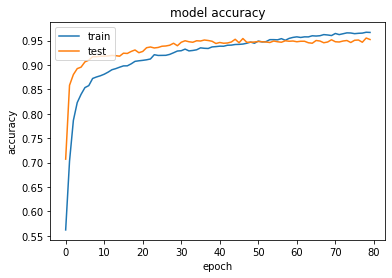

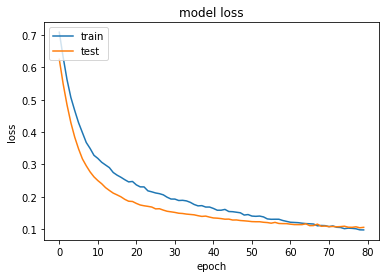

1445/1445 [==============================] - 0s 68us/step
[0.1332496932324241, 0.9446367025375366]
AUC: 0.9910126137442707


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.863668  1.000000   0.525301  0.919723  0.688784  0.580405
1             0.10  0.896886  1.000000   0.594005  0.939283  0.745299  0.646501
2             0.15  0.908651  0.986239   0.625000  0.940552  0.765125  0.674404
3             0.20  0.919723  0.986239   0.655488  0.947072  0.787546  0.702614
4             0.25  0.923183  0.981651   0.666667  0.947223  0.794063  0.712383
5             0.30  0.927336  0.981651   0.679365  0.949668  0.803002  0.723951
6             0.35  0.932872  0.972477   0.699670  0.949156  0.813820  0.741259
7             0.40  0.937024  0.972477   0.713805  0.951601  0.823301  0.753912
8             0.45  0.939792  0.967890   0.725086  0.951345  0.829077  0.763386
9             0.50  0.944637  0.963303   0.744681  0.952312  0.840000  0.780089
10            0.55  0.947405  0.954128   0.759124  0.950169  0.845528  0.791476
11            0.60  0.952941  0.954128  

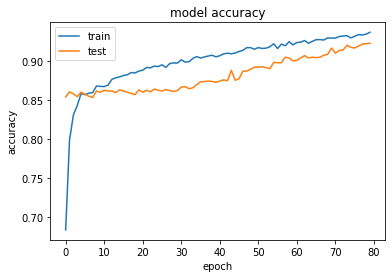

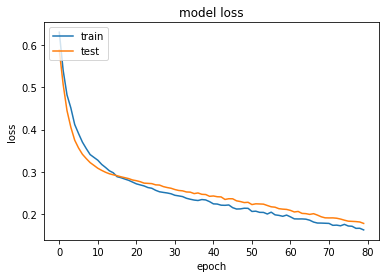

1445/1445 [==============================] - 0s 72us/step
[0.15351592086796942, 0.9418684840202332]
AUC: 0.9814906200698356


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.753633  0.990826   0.378947  0.851159  0.548223  0.432346
1             0.10  0.820069  0.986239   0.455508  0.888392  0.623188  0.510446
2             0.15  0.851211  0.977064   0.503546  0.902958  0.664587  0.557592
3             0.20  0.871972  0.977064   0.541985  0.915182  0.697218  0.594972
4             0.25  0.892042  0.977064   0.585165  0.927000  0.731959  0.636201
5             0.30  0.905882  0.963303   0.621302  0.929492  0.755396  0.668790
6             0.35  0.914187  0.949541   0.646875  0.928723  0.769517  0.690921
7             0.40  0.921107  0.944954   0.668831  0.930912  0.783270  0.710345
8             0.45  0.932180  0.940367   0.706897  0.935546  0.807087  0.743832
9             0.50  0.941869  0.931193   0.746324  0.937479  0.828571  0.777182
10            0.55  0.946713  0.912844   0.774319  0.932787  0.837895  0.798555
11            0.60  0.952941  0.903670  

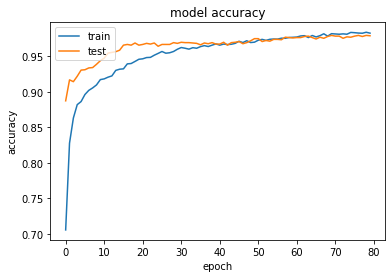

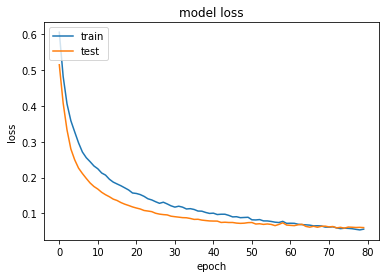

1445/1445 [==============================] - 0s 102us/step
[0.08259466940917358, 0.9702422022819519]
AUC: 0.9928968245067031


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.928028  0.990826   0.679245  0.953848  0.805970  0.724832
1             0.10  0.943253  0.977064   0.734483  0.957155  0.838583  0.772859
2             0.15  0.950173  0.977064   0.760714  0.961230  0.855422  0.795964
3             0.20  0.953633  0.977064   0.774545  0.963267  0.864097  0.808042
4             0.25  0.956401  0.972477   0.788104  0.963011  0.870637  0.819165
5             0.30  0.961246  0.972477   0.809160  0.965864  0.883333  0.837283
6             0.35  0.964706  0.972477   0.824903  0.967901  0.892632  0.850722
7             0.40  0.966782  0.972477   0.834646  0.969124  0.898305  0.858995
8             0.45  0.967474  0.967890   0.840637  0.967645  0.899787  0.863339
9             0.50  0.970242  0.967890   0.854251  0.969275  0.907527  0.874793
10            0.55  0.973010  0.967890   0.868313  0.970905  0.915401  0.886555
11            0.60  0.975087  0.967890  

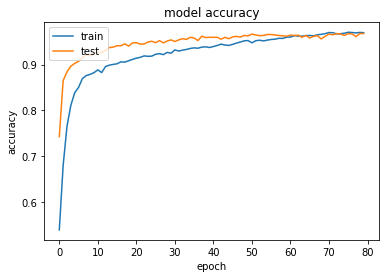

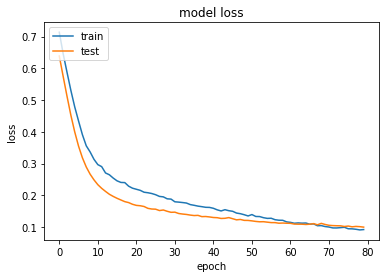

1445/1445 [==============================] - 0s 72us/step
[0.1542898193465797, 0.9494809508323669]
AUC: 0.9777462438639224


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.860900  0.986301   0.521739  0.912400  0.682464  0.576000
1             0.10  0.885121  0.986301   0.569921  0.926674  0.722408  0.622478
2             0.15  0.894810  0.981735   0.592287  0.930509  0.738832  0.643327
3             0.20  0.905190  0.981735   0.617816  0.936626  0.758377  0.667287
4             0.25  0.914187  0.968037   0.644377  0.936302  0.773723  0.690554
5             0.30  0.921799  0.963470   0.667722  0.938913  0.788785  0.711396
6             0.35  0.926644  0.963470   0.682848  0.941768  0.799242  0.725086
7             0.40  0.934256  0.963470   0.708054  0.946254  0.816248  0.747697
8             0.45  0.942561  0.963470   0.737762  0.951148  0.835644  0.774028
9             0.50  0.949481  0.954338   0.768382  0.951476  0.851324  0.799541
10            0.55  0.951557  0.949772   0.779026  0.950824  0.855967  0.808081
11            0.60  0.955709  0.936073  

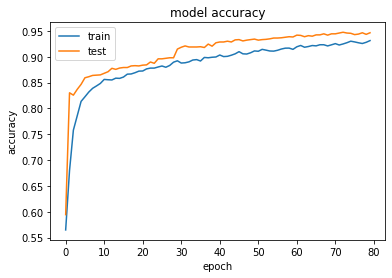

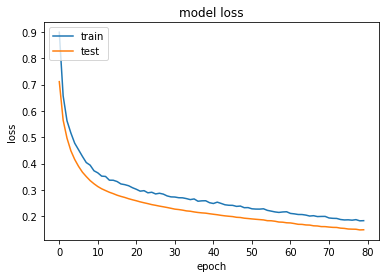

1445/1445 [==============================] - 0s 74us/step
[0.18204574790947578, 0.9128027558326721]
AUC: 0.9739919700254009


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.740484  0.981735   0.366894  0.839563  0.534161  0.419430
1             0.10  0.812457  0.981735   0.446058  0.881977  0.613409  0.500699
2             0.15  0.851903  0.977169   0.505910  0.903348  0.666667  0.559916
3             0.20  0.869204  0.968037   0.538071  0.909793  0.691680  0.590529
4             0.25  0.878201  0.958904   0.557029  0.911344  0.704698  0.607991
5             0.30  0.889273  0.949772   0.582633  0.914119  0.722222  0.631451
6             0.35  0.893426  0.949772   0.592593  0.916566  0.729825  0.640789
7             0.40  0.901730  0.940639   0.614925  0.917710  0.743682  0.660680
8             0.45  0.903114  0.926941   0.620795  0.912899  0.743590  0.664702
9             0.50  0.912803  0.922374   0.649518  0.916734  0.762264  0.690362
10            0.55  0.918339  0.904110   0.671186  0.912495  0.770428  0.707648
11            0.60  0.930104  0.894977  

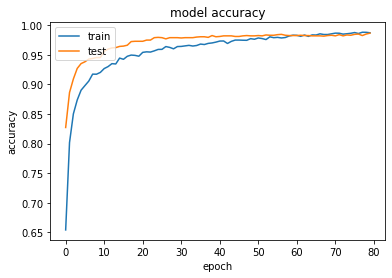

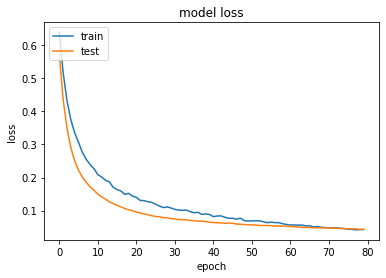

1445/1445 [==============================] - 0s 109us/step
[0.07346923171726272, 0.9757785201072693]
AUC: 0.9925212481470721


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.938408  0.995434   0.712418  0.961828  0.830476  0.755371
1             0.10  0.950173  0.986301   0.757895  0.965010  0.857143  0.794702
2             0.15  0.954325  0.986301   0.774194  0.967457  0.867470  0.808989
3             0.20  0.962630  0.981735   0.811321  0.970476  0.888430  0.840500
4             0.25  0.964706  0.981735   0.820611  0.971700  0.893971  0.848461
5             0.30  0.965398  0.977169   0.826255  0.970232  0.895397  0.852590
6             0.35  0.967474  0.972603   0.838583  0.969580  0.900634  0.862348
7             0.40  0.970242  0.968037   0.854839  0.969336  0.907923  0.875310
8             0.45  0.974394  0.963470   0.879167  0.969908  0.919390  0.894826
9             0.50  0.975779  0.958904   0.889831  0.968848  0.923077  0.902837
10            0.55  0.976471  0.954338   0.896996  0.967381  0.924779  0.907906
11            0.60  0.977163  0.949772  

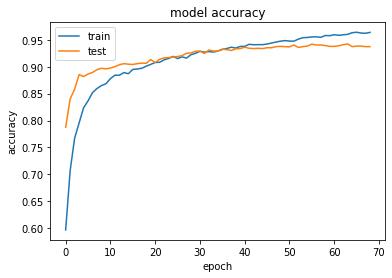

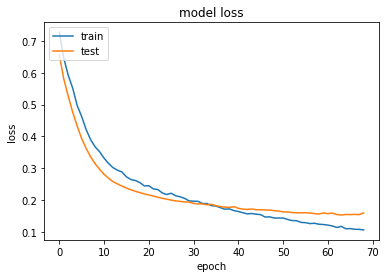

1445/1445 [==============================] - 0s 69us/step
[0.15341583369718703, 0.9370242357254028]
AUC: 0.9866253994502671


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.831142  1.000000   0.473002  0.900489  0.642229  0.528730
1             0.10  0.862284  0.995434   0.524038  0.916966  0.686614  0.578864
2             0.15  0.880969  0.990868   0.560724  0.926103  0.716172  0.614035
3             0.20  0.894810  0.986301   0.591781  0.932384  0.739726  0.643240
4             0.25  0.910035  0.986301   0.629738  0.941356  0.768683  0.678818
5             0.30  0.915571  0.981735   0.645646  0.942744  0.778986  0.693101
6             0.35  0.926644  0.981735   0.678233  0.949269  0.802239  0.722932
7             0.40  0.930796  0.972603   0.693811  0.947965  0.809886  0.736006
8             0.45  0.935640  0.972603   0.710000  0.950820  0.820809  0.750529
9             0.50  0.937024  0.963470   0.717687  0.947885  0.822612  0.756272
10            0.55  0.940484  0.963470   0.730104  0.949924  0.830709  0.767273
11            0.60  0.943253  0.949772  

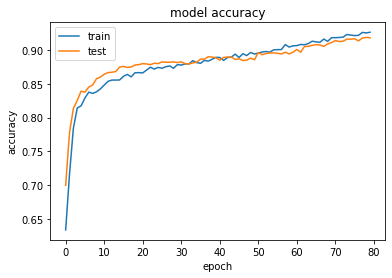

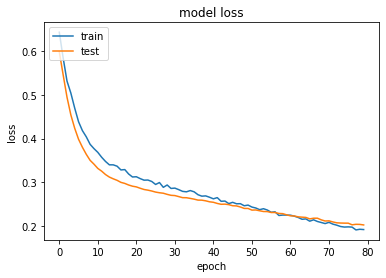

1445/1445 [==============================] - 0s 76us/step
[0.1674078678950719, 0.9363321661949158]
AUC: 0.9774594590568132


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.711419  0.995434   0.343849  0.828059  0.511137  0.395644
1             0.10  0.789619  0.986301   0.417795  0.870394  0.586957  0.472234
2             0.15  0.828374  0.968037   0.467991  0.885731  0.630952  0.521910
3             0.20  0.858131  0.958904   0.517241  0.899517  0.672000  0.569723
4             0.25  0.876817  0.949772   0.554667  0.906778  0.700337  0.605003
5             0.30  0.888581  0.945205   0.581461  0.911836  0.720000  0.629945
6             0.35  0.901038  0.940639   0.613095  0.917302  0.742342  0.658989
7             0.40  0.908651  0.931507   0.635514  0.918037  0.755556  0.678643
8             0.45  0.919723  0.926941   0.669967  0.922687  0.777778  0.709294
9             0.50  0.936332  0.917808   0.730909  0.928725  0.813765  0.761941
10            0.55  0.946021  0.913242   0.772201  0.932559  0.836820  0.796813
11            0.60  0.952249  0.894977  

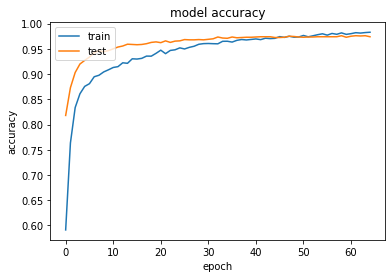

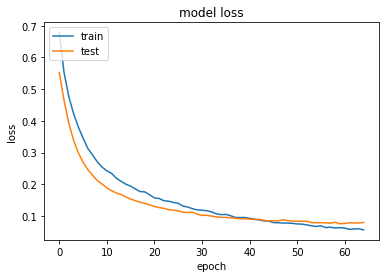

1445/1445 [==============================] - 0s 100us/step
[0.08657216574597111, 0.9695501923561096]
AUC: 0.9940184883088635


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.913495  0.995434   0.637427  0.947146  0.777184  0.686830
1             0.10  0.937716  0.995434   0.710098  0.961420  0.828897  0.753283
2             0.15  0.948789  0.990868   0.750865  0.966070  0.854331  0.789091
3             0.20  0.953633  0.990868   0.769504  0.968925  0.866267  0.805494
4             0.25  0.957093  0.990868   0.783394  0.970964  0.875000  0.817634
5             0.30  0.961246  0.990868   0.800738  0.973411  0.885714  0.832694
6             0.35  0.964014  0.990868   0.812734  0.975042  0.893004  0.843046
7             0.40  0.966782  0.990868   0.825095  0.976674  0.900415  0.853659
8             0.45  0.967474  0.986301   0.830769  0.975206  0.901879  0.857824
9             0.50  0.969550  0.981735   0.843137  0.974554  0.907173  0.867635
10            0.55  0.971626  0.981735   0.853175  0.975778  0.912951  0.876121
11            0.60  0.973702  0.977169  

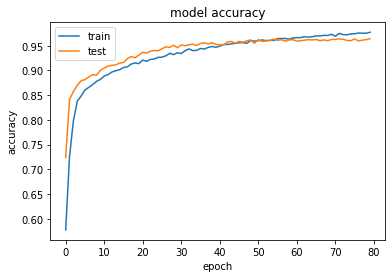

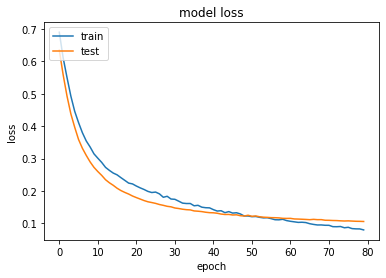

1445/1445 [==============================] - 0s 72us/step
[0.12387814416604884, 0.9487889409065247]
AUC: 0.9886179951879744


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.884429  0.986301   0.568421  0.926267  0.721202  0.621047
1             0.10  0.909343  0.981735   0.628655  0.939073  0.766488  0.677379
2             0.15  0.923183  0.981735   0.667702  0.947230  0.794824  0.713338
3             0.20  0.936332  0.977169   0.710963  0.953103  0.823077  0.751933
4             0.25  0.940484  0.977169   0.725424  0.955550  0.832685  0.764832
5             0.30  0.942561  0.963470   0.737762  0.951148  0.835644  0.774028
6             0.35  0.943945  0.958904   0.744681  0.950088  0.838323  0.779510
7             0.40  0.948097  0.958904   0.760870  0.952535  0.848485  0.793651
8             0.45  0.947405  0.945205   0.763838  0.946502  0.844898  0.794321
9             0.50  0.948789  0.936073   0.773585  0.943567  0.847107  0.801407
10            0.55  0.951557  0.931507   0.787645  0.943323  0.853556  0.812749
11            0.60  0.955017  0.926941  

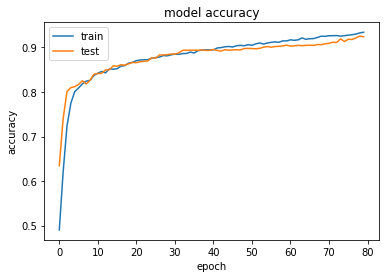

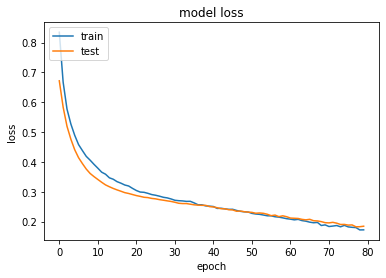

1445/1445 [==============================] - 0s 67us/step
[0.18109704175622404, 0.9328719973564148]
AUC: 0.9766363494156294


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.735640  0.995434   0.363940  0.842334  0.533007  0.416826
1             0.10  0.818685  0.995434   0.455115  0.891273  0.624642  0.510539
2             0.15  0.852595  0.986301   0.507042  0.907506  0.669767  0.561622
3             0.20  0.872664  0.981735   0.544304  0.917458  0.700326  0.597554
4             0.25  0.887889  0.981735   0.576408  0.926430  0.726351  0.628288
5             0.30  0.895502  0.963470   0.596045  0.923415  0.736475  0.645260
6             0.35  0.903806  0.963470   0.616959  0.928309  0.752228  0.664776
7             0.40  0.918339  0.963470   0.657321  0.936874  0.781481  0.701929
8             0.45  0.930796  0.949772   0.700337  0.938589  0.806202  0.739161
9             0.50  0.932872  0.913242   0.719424  0.924810  0.804829  0.751315
10            0.55  0.935640  0.913242   0.729927  0.926442  0.811359  0.760456
11            0.60  0.937716  0.894977  

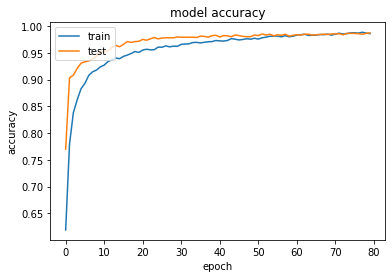

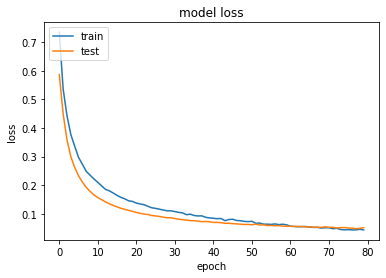

1445/1445 [==============================] - 0s 99us/step
[0.06532861644564886, 0.9757785201072693]
AUC: 0.9956237383330726


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.949481  0.995434   0.751724  0.968353  0.856582  0.790428
1             0.10  0.959862  0.995434   0.792727  0.974471  0.882591  0.826384
2             0.15  0.964706  0.995434   0.813433  0.977325  0.895277  0.844307
3             0.20  0.968858  0.995434   0.832061  0.979772  0.906445  0.860300
4             0.25  0.969550  0.986301   0.840467  0.976430  0.907563  0.866079
5             0.30  0.972318  0.986301   0.853755  0.978061  0.915254  0.877335
6             0.35  0.974394  0.986301   0.864000  0.979284  0.921109  0.885972
7             0.40  0.975087  0.972603   0.876543  0.974066  0.922078  0.894207
8             0.45  0.975779  0.968037   0.883333  0.972599  0.923747  0.899067
9             0.50  0.975779  0.963470   0.886555  0.970724  0.923414  0.900939
10            0.55  0.975779  0.958904   0.889831  0.968848  0.923077  0.902837
11            0.60  0.975779  0.954338  

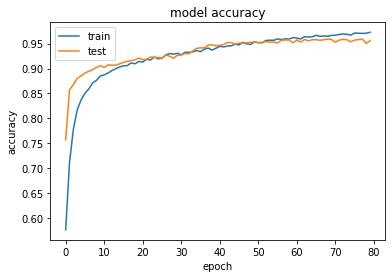

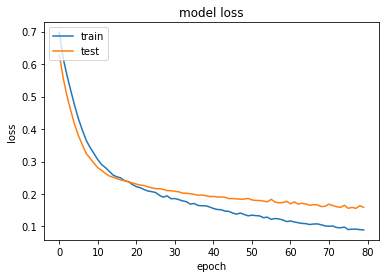

1445/1445 [==============================] - 0s 77us/step
[0.09355621165418708, 0.9598615765571594]
AUC: 0.9933071130081119


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.889965  0.995434   0.579787  0.933280  0.732773  0.632618
1             0.10  0.921799  0.995434   0.660606  0.952040  0.794171  0.708252
2             0.15  0.932180  0.990868   0.693291  0.956282  0.815789  0.737593
3             0.20  0.939100  0.986301   0.717608  0.958485  0.830769  0.758960
4             0.25  0.943253  0.981735   0.733788  0.959057  0.839844  0.772825
5             0.30  0.948097  0.977169   0.753521  0.960036  0.850895  0.789668
6             0.35  0.954325  0.977169   0.778182  0.963707  0.866397  0.811221
7             0.40  0.955709  0.972603   0.785978  0.962647  0.869388  0.817345
8             0.45  0.956401  0.963470   0.793233  0.959304  0.870103  0.822292
9             0.50  0.959862  0.954338   0.813230  0.957593  0.878151  0.838011
10            0.55  0.962630  0.945205   0.831325  0.955474  0.884615  0.851852
11            0.60  0.963322  0.936073  

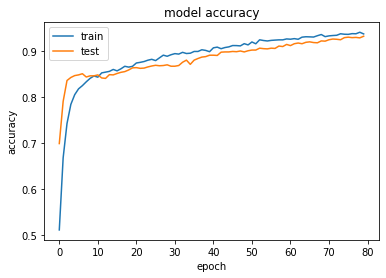

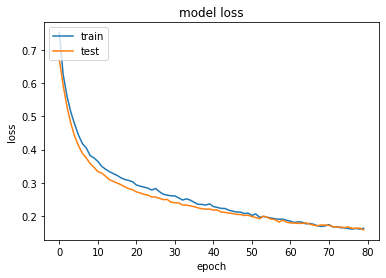

1445/1445 [==============================] - 0s 71us/step
[0.12984490035211338, 0.9529411792755127]
AUC: 0.9875043762616669


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.765398  1.000000   0.392473  0.861746  0.563707  0.446756
1             0.10  0.828374  0.995434   0.468817  0.896983  0.637427  0.524291
2             0.15  0.883737  0.995434   0.566234  0.929609  0.721854  0.619670
3             0.20  0.903114  0.981735   0.612536  0.935403  0.754386  0.662354
4             0.25  0.912111  0.972603   0.637725  0.936954  0.770344  0.684887
5             0.30  0.921107  0.972603   0.663551  0.942256  0.788889  0.708583
6             0.35  0.928720  0.949772   0.693333  0.937365  0.801541  0.732911
7             0.40  0.944637  0.945205   0.752727  0.944870  0.838057  0.784685
8             0.45  0.948789  0.940639   0.771536  0.945442  0.847737  0.800311
9             0.50  0.952941  0.917808   0.800797  0.938513  0.855319  0.821750
10            0.55  0.955017  0.899543   0.820833  0.932235  0.858388  0.835454
11            0.60  0.955709  0.876712  

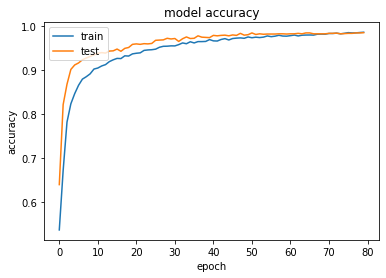

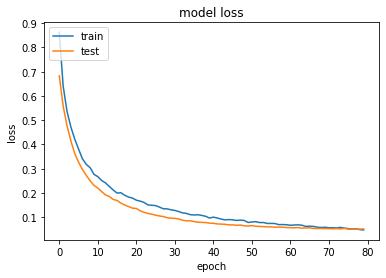

1445/1445 [==============================] - 0s 102us/step
[0.05537854145106998, 0.9813148975372314]
AUC: 0.9967392194983873
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.952941  1.000000   0.763066  0.972268  0.865613  0.801024
1             0.10  0.962630  0.990868   0.806691  0.974227  0.889344  0.837838
2             0.15  0.967474  0.990868   0.828244  0.977081  0.902287  0.856354
3             0.20  0.970934  0.986301   0.847059  0.977245  0.911392  0.871671
4             0.25  0.977855  0.981735   0.884774  0.979448  0.930736  0.902603
5             0.30  0.978547  0.981735   0.888430  0.979856  0.932755  0.905644
6             0.35  0.978547  0.977169   0.891667  0.977981  0.932462  0.907549
7             0.40  0.979931  0.977169   0.899160  0.978797  0.936543  0.913749
8             0.45  0.979931  0.972603   0.902542  0.976921  0.936264  0.915735
9             0.50  0.981315  0.968037   0.913793  0.975862  0.940133  0.92

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
selected_class = 'subclass_IV_1'
y = df_Y_total[selected_class]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
for train_index, test_index in skf.split(np.zeros(y.shape[0]), y):
  print('Start split###########################################################')
  xa_train, xa_test, xd_train, xd_test, y_train, y_test = xa[train_index], xa[test_index], xd[train_index], xd[test_index], y[train_index], y[test_index]

  xa_train, xa_val, xd_train, xd_val, y_train, y_val = train_test_split(xa_train, xd_train, y_train, random_state=10, 
                                                                           test_size=0.2, stratify=y_train)
  from collections import Counter
  print(xa_train.shape, xa_val.shape, xa_test.shape)
  print(xd_train.shape, xd_val.shape, xd_test.shape)
  print(y_train.shape, y_val.shape, y_test.shape)
  print(Counter(y_train), Counter(y_val), Counter(y_test))

  xa_train_resampled, xd_train_resampled, y_train_resampled = resample(xa_train, xd_train, y_train)
  xa_val_resampled, xd_val_resampled, y_val_resampled = resample(xa_val, xd_val, y_val)

  from utils import modeler
  from keras.callbacks import EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  num_epochs = 80
  batch_size = 64

  # Arq7xal
  print('Training Arq7xal model----------------------------------------------------------')
  model = modeler.make_arq7xal_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xa_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xa_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xa_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xa_test)))

  # Arq7xdl
  print('Training Arq7xdl model----------------------------------------------------------')
  model = modeler.make_arq7xdl_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xd_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xd_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xd_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xd_test)))

  print('Training Arq7 model----------------------------------------------------------')
  # Arq7
  model = modeler.make_arq7_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit([xa_train_resampled, xd_train_resampled], y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=([xa_val_resampled, xd_val_resampled],y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate([xa_test,xd_test],y_test))
  print(get_threshold_measures_df(y_test,model.predict([xa_test,xd_test])))

  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Start split###########################################################
(4624, 12, 12, 5) (1156, 12, 12, 5) (1445, 12, 12, 5)
(4624, 20, 15) (1156, 20, 15) (1445, 20, 15)
(4624,) (1156,) (1445,)
Counter({0.0: 4069, 1.0: 555}) Counter({0.0: 1017, 1.0: 139}) Counter({0.0: 1272, 1.0: 173})
Correct resample:  True
(8138, 12, 12, 5)
(8138, 20, 15)
Correct resample:  True
(2034, 12, 12, 5)
(2034, 20, 15)
Training Arq7xal model----------------------------------------------------------
Train on 8138 samples, validate on 2034 samples
Epoch 1/80
 - 1s - loss: 0.8642 - accuracy: 0.5097 - val_loss: 0.6206 - val_accuracy: 0.7060
Epoch 2/80
 - 1s - loss: 0.5753 - accuracy: 0.7594 - val_loss: 0.5109 - val_accuracy: 0.8505
Epoch 3/80
 - 1s - loss: 0.4887 - accuracy: 0.8304 - val_loss: 0.4559 - val_accuracy: 0.8643
Epoch 4/80
 - 1s - loss: 0.4363 - accuracy: 0.8528 - val_loss: 0.4155 - val_accuracy: 0.8653
Epoch 5/80
 - 1s - loss: 0.4035 - accuracy: 0.8560 - val_loss: 0.3865 - val_accuracy: 0.8658
Epoch

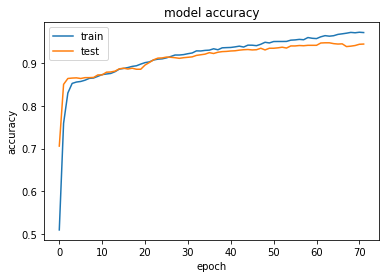

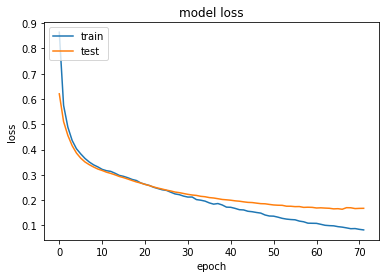

1445/1445 [==============================] - 0s 67us/step
[0.14440914698744314, 0.9377162456512451]
AUC: 0.9894617733667794


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.828374  0.994220   0.410501  0.900019  0.581081  0.465116
1             0.10  0.856747  0.988439   0.454787  0.913638  0.622951  0.509839
2             0.15  0.869896  0.988439   0.478992  0.921106  0.645283  0.534041
3             0.20  0.885121  0.982659   0.510511  0.927257  0.671937  0.564784
4             0.25  0.894118  0.982659   0.531250  0.932367  0.689655  0.584997
5             0.30  0.898962  0.976879   0.543408  0.932622  0.698347  0.596330
6             0.35  0.910727  0.976879   0.574830  0.939304  0.723769  0.626390
7             0.40  0.917647  0.976879   0.595070  0.943235  0.739606  0.645531
8             0.45  0.925260  0.971098   0.619926  0.945062  0.756757  0.668258
9             0.50  0.937716  0.971098   0.664032  0.952137  0.788732  0.708861
10            0.55  0.940484  0.953757   0.679012  0.946218  0.793269  0.720524
11            0.60  0.945329  0.953757  

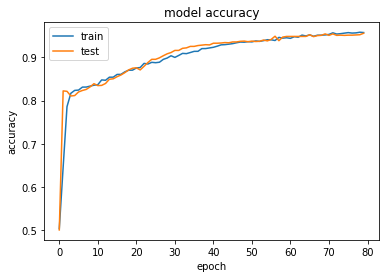

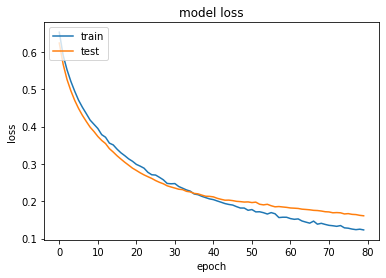

1445/1445 [==============================] - 0s 72us/step
[0.11586757322908685, 0.9584774971008301]
AUC: 0.9881530155960301


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.777163  0.982659   0.347648  0.865936  0.513595  0.399248
1             0.10  0.851211  0.976879   0.444737  0.905499  0.611212  0.499114
2             0.15  0.887197  0.971098   0.515337  0.923442  0.673347  0.568720
3             0.20  0.913495  0.971098   0.583333  0.938379  0.728850  0.633962
4             0.25  0.923183  0.965318   0.613971  0.941385  0.750562  0.662173
5             0.30  0.934256  0.959538   0.653543  0.945178  0.777518  0.698066
6             0.35  0.943945  0.953757   0.693277  0.948184  0.802920  0.733333
7             0.40  0.949481  0.953757   0.717391  0.951328  0.818859  0.754803
8             0.45  0.953633  0.947977   0.738739  0.951190  0.830380  0.772856
9             0.50  0.958478  0.942197   0.765258  0.951444  0.844560  0.795122
10            0.55  0.961938  0.942197   0.783654  0.953410  0.855643  0.810945
11            0.60  0.964014  0.936416  

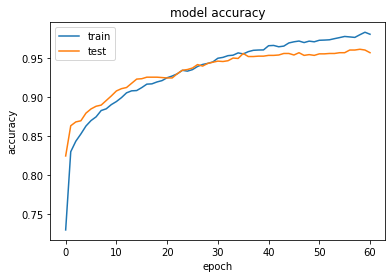

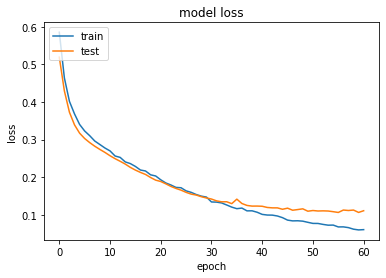

1445/1445 [==============================] - 0s 100us/step
[0.08039405939900751, 0.9647058844566345]
AUC: 0.9952966517613698


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.874740  0.994220   0.488636  0.926355  0.655238  0.543960
1             0.10  0.896194  0.994220   0.535826  0.938541  0.696356  0.590254
2             0.15  0.923183  0.994220   0.609929  0.953871  0.756044  0.661030
3             0.20  0.933564  0.988439   0.645283  0.957270  0.780822  0.693431
4             0.25  0.943253  0.988439   0.681275  0.962773  0.806604  0.726423
5             0.30  0.949481  0.988439   0.706612  0.966311  0.824096  0.749343
6             0.35  0.960554  0.988439   0.756637  0.972600  0.857143  0.793872
7             0.40  0.960554  0.982659   0.758929  0.970103  0.856423  0.795136
8             0.45  0.964014  0.982659   0.776256  0.972068  0.867347  0.810296
9             0.50  0.964706  0.976879   0.782407  0.969964  0.868895  0.814851
10            0.55  0.971626  0.971098   0.823529  0.971398  0.891247  0.849343
11            0.60  0.975087  0.971098  

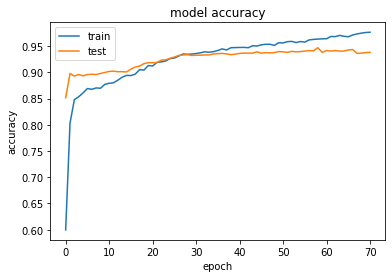

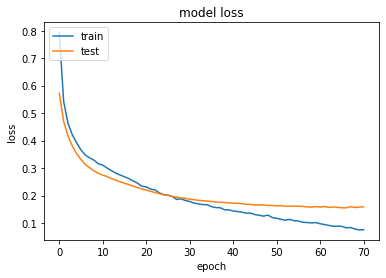

1445/1445 [==============================] - 0s 83us/step
[0.16141123277486452, 0.928719699382782]
AUC: 0.9751654124404696


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.838062  0.965318   0.422785  0.893036  0.588028  0.476326
1             0.10  0.865052  0.959538   0.468927  0.905869  0.629981  0.522341
2             0.15  0.876125  0.953757   0.491071  0.909662  0.648330  0.543837
3             0.20  0.887197  0.947977   0.515723  0.913454  0.668024  0.567474
4             0.25  0.889965  0.930636   0.522727  0.907535  0.669439  0.572954
5             0.30  0.897578  0.930636   0.542088  0.911859  0.685106  0.591477
6             0.35  0.903114  0.919075   0.557895  0.910009  0.694323  0.605484
7             0.40  0.916955  0.907514   0.601533  0.912877  0.723502  0.645029
8             0.45  0.924567  0.901734   0.629032  0.914704  0.741093  0.669528
9             0.50  0.928720  0.890173   0.647059  0.912068  0.749392  0.684444
10            0.55  0.934256  0.884393   0.671053  0.912715  0.763092  0.705069
11            0.60  0.939792  0.872832  

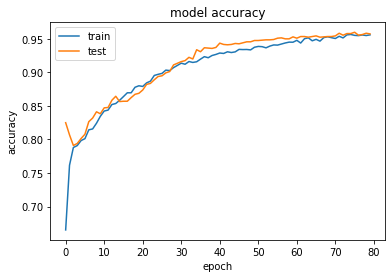

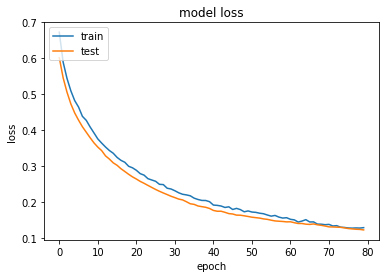

1445/1445 [==============================] - 0s 69us/step
[0.14100627292811252, 0.9522491097450256]
AUC: 0.9877758388773766


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.767474  0.988439   0.338614  0.862930  0.504425  0.389877
1             0.10  0.817301  0.988439   0.394919  0.891232  0.564356  0.448819
2             0.15  0.870588  0.988439   0.480337  0.921500  0.646503  0.535379
3             0.20  0.892042  0.982659   0.526316  0.931188  0.685484  0.580205
4             0.25  0.907958  0.976879   0.567114  0.937732  0.717622  0.619048
5             0.30  0.919723  0.965318   0.602888  0.939420  0.742222  0.651835
6             0.35  0.929412  0.959538   0.636015  0.942426  0.764977  0.682005
7             0.40  0.939100  0.959538   0.672065  0.947929  0.790476  0.714901
8             0.45  0.945329  0.959538   0.697479  0.951467  0.807786  0.737778
9             0.50  0.952249  0.959538   0.728070  0.955398  0.827930  0.764977
10            0.55  0.955017  0.953757   0.743243  0.954473  0.835443  0.777568
11            0.60  0.955017  0.936416  

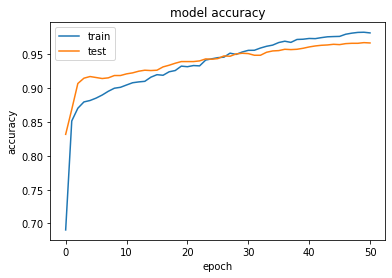

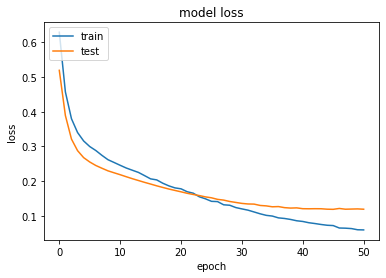

1445/1445 [==============================] - 0s 104us/step
[0.09192581248798352, 0.9598615765571594]
AUC: 0.9920020358454211


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.860208  0.994220   0.461126  0.918100  0.630037  0.516517
1             0.10  0.889273  0.988439   0.519757  0.932113  0.681275  0.574211
2             0.15  0.906574  0.976879   0.563333  0.936946  0.714588  0.615441
3             0.20  0.916263  0.959538   0.592857  0.934957  0.732892  0.641918
4             0.25  0.934256  0.959538   0.653543  0.945178  0.777518  0.698066
5             0.30  0.942561  0.959538   0.685950  0.949895  0.800000  0.727432
6             0.35  0.948789  0.959538   0.712446  0.953432  0.817734  0.751131
7             0.40  0.954325  0.959538   0.737778  0.956577  0.834171  0.773532
8             0.45  0.956401  0.947977   0.752294  0.952762  0.838875  0.784689
9             0.50  0.959862  0.942197   0.772512  0.952230  0.848958  0.801377
10            0.55  0.962630  0.936416   0.790244  0.951306  0.857143  0.815710
11            0.60  0.964706  0.924855  

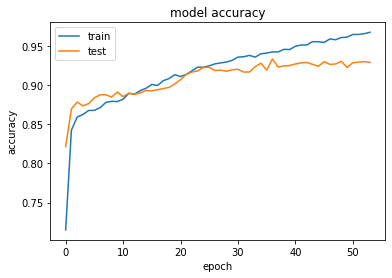

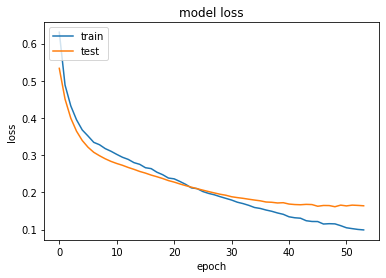

1445/1445 [==============================] - 0s 79us/step
[0.16673798047547522, 0.921107292175293]
AUC: 0.9845130330461337


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.806228  0.994220   0.381375  0.887440  0.551282  0.435003
1             0.10  0.838754  0.994220   0.425743  0.905915  0.596187  0.480715
2             0.15  0.853979  0.988439   0.450000  0.912066  0.618445  0.505021
3             0.20  0.866436  0.988439   0.472376  0.919141  0.639252  0.527452
4             0.25  0.881661  0.988439   0.502941  0.927789  0.666667  0.557730
5             0.30  0.890657  0.988439   0.522936  0.932899  0.684000  0.577313
6             0.35  0.897578  0.976879   0.539936  0.931836  0.695473  0.592982
7             0.40  0.907266  0.971098   0.565657  0.934842  0.714894  0.617193
8             0.45  0.915571  0.965318   0.590106  0.937061  0.732456  0.639847
9             0.50  0.921107  0.947977   0.609665  0.932715  0.742081  0.656525
10            0.55  0.928028  0.930636   0.636364  0.929154  0.755869  0.679325
11            0.60  0.932872  0.924855  

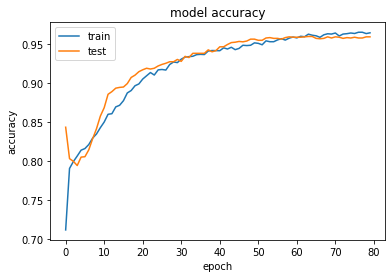

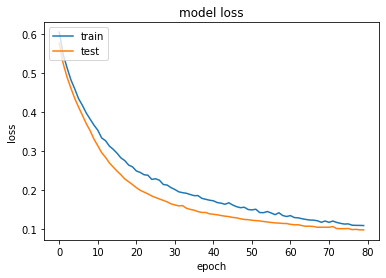

1445/1445 [==============================] - 0s 81us/step
[0.09855782744381254, 0.9674740433692932]
AUC: 0.9927018577089468


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.806920  0.994220   0.382222  0.887833  0.552167  0.435884
1             0.10  0.866436  0.988439   0.472376  0.919141  0.639252  0.527452
2             0.15  0.900346  0.982659   0.546624  0.935905  0.702479  0.599859
3             0.20  0.928720  0.982659   0.629630  0.952021  0.767494  0.678372
4             0.25  0.937716  0.982659   0.661479  0.957131  0.790698  0.707744
5             0.30  0.948097  0.982659   0.702479  0.963028  0.819277  0.744961
6             0.35  0.950865  0.965318   0.719828  0.957109  0.824691  0.758401
7             0.40  0.955709  0.965318   0.742222  0.959860  0.839196  0.778192
8             0.45  0.961246  0.965318   0.769585  0.963005  0.856410  0.802113
9             0.50  0.967474  0.965318   0.802885  0.966543  0.876640  0.830846
10            0.55  0.969550  0.953757   0.820896  0.962728  0.882353  0.844422
11            0.60  0.973010  0.953757  

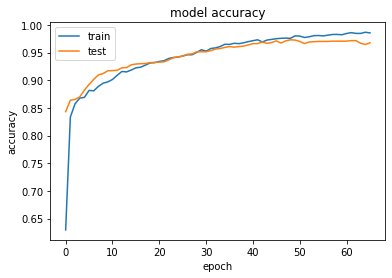

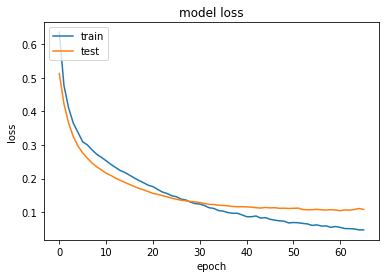

1445/1445 [==============================] - 0s 103us/step
[0.06417464458457739, 0.970934271812439]
AUC: 0.9947831461082633


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.893426  0.994220   0.529231  0.936968  0.690763  0.583842
1             0.10  0.924567  0.988439   0.615108  0.952160  0.758315  0.665370
2             0.15  0.936332  0.982659   0.656371  0.956345  0.787037  0.703060
3             0.20  0.944637  0.976879   0.689796  0.958565  0.808612  0.732871
4             0.25  0.948789  0.976879   0.707113  0.960924  0.820388  0.748450
5             0.30  0.952941  0.971098   0.727273  0.960785  0.831683  0.765725
6             0.35  0.961246  0.971098   0.767123  0.965502  0.857143  0.800763
7             0.40  0.964014  0.971098   0.781395  0.967074  0.865979  0.813166
8             0.45  0.968166  0.971098   0.803828  0.969433  0.879581  0.832507
9             0.50  0.970934  0.971098   0.819512  0.971005  0.888889  0.845921
10            0.55  0.977855  0.971098   0.861538  0.974936  0.913043  0.881427
11            0.60  0.979931  0.953757  

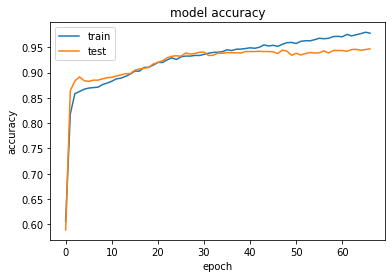

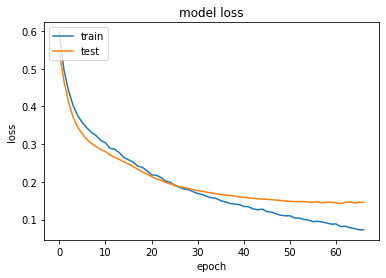

1445/1445 [==============================] - 0s 69us/step
[0.1125741603246094, 0.9515570998191833]
AUC: 0.9896090507067473


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.855363  0.988506   0.453826  0.912821  0.622061  0.508876
1             0.10  0.880969  0.982759   0.502941  0.924896  0.665370  0.557366
2             0.15  0.897578  0.982759   0.541139  0.934338  0.697959  0.594576
3             0.20  0.902422  0.977011   0.553746  0.934611  0.706861  0.606277
4             0.25  0.908651  0.971264   0.570946  0.935672  0.719149  0.622239
5             0.30  0.921107  0.971264   0.607914  0.942753  0.747788  0.657076
6             0.35  0.932180  0.971264   0.645038  0.949047  0.775229  0.691489
7             0.40  0.937716  0.971264   0.665354  0.952194  0.789720  0.710084
8             0.45  0.944637  0.959770   0.695833  0.951168  0.806763  0.736332
9             0.50  0.951557  0.936782   0.734234  0.945181  0.823232  0.767420
10            0.55  0.957785  0.931034   0.767773  0.946241  0.841558  0.795678
11            0.60  0.959862  0.925287  

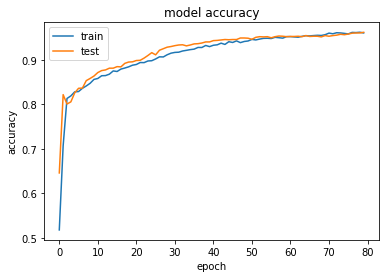

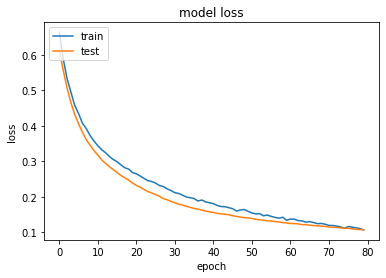

1445/1445 [==============================] - 0s 70us/step
[0.12671284453885365, 0.9564014077186584]
AUC: 0.9891297466923502


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.797232  0.994253   0.372043  0.882256  0.541471  0.425270
1             0.10  0.838062  0.994253   0.426108  0.905466  0.596552  0.481090
2             0.15  0.885121  0.994253   0.511834  0.932217  0.675781  0.566841
3             0.20  0.898270  0.994253   0.542320  0.939691  0.701826  0.596552
4             0.25  0.914879  0.994253   0.586441  0.949133  0.737740  0.638848
5             0.30  0.924567  0.994253   0.615658  0.954640  0.760440  0.666410
6             0.35  0.931488  0.982759   0.640449  0.953614  0.775510  0.688406
7             0.40  0.941176  0.982759   0.675889  0.959121  0.800937  0.720911
8             0.45  0.948789  0.977011   0.708333  0.960968  0.821256  0.749559
9             0.50  0.956401  0.971264   0.744493  0.962816  0.842893  0.780961
10            0.55  0.962630  0.954023   0.783019  0.958916  0.860104  0.812133
11            0.60  0.966090  0.954023  

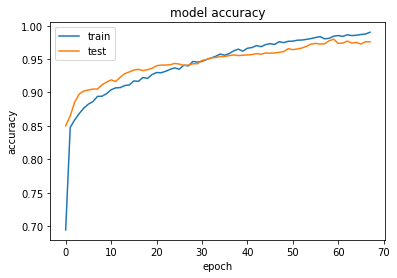

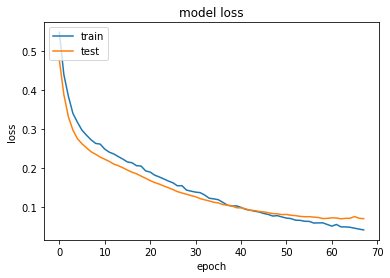

1445/1445 [==============================] - 0s 106us/step
[0.06110095463203311, 0.979238748550415]
AUC: 0.9938911346844279


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.916955  0.994253   0.592466  0.950313  0.742489  0.644560
1             0.10  0.939792  0.994253   0.667954  0.963295  0.799076  0.714876
2             0.15  0.950173  0.988506   0.710744  0.966716  0.826923  0.753065
3             0.20  0.955017  0.982759   0.733906  0.966989  0.840295  0.773056
4             0.25  0.960554  0.977011   0.762332  0.967656  0.856423  0.797373
5             0.30  0.965398  0.977011   0.787037  0.970410  0.871795  0.818882
6             0.35  0.968166  0.971264   0.804762  0.969503  0.880208  0.833333
7             0.40  0.973702  0.971264   0.836634  0.972650  0.898936  0.860489
8             0.45  0.977855  0.971264   0.862245  0.975011  0.913514  0.882046
9             0.50  0.979239  0.971264   0.871134  0.975797  0.918478  0.889474
10            0.55  0.982699  0.971264   0.894180  0.977764  0.931129  0.908602
11            0.60  0.985467  0.965517  

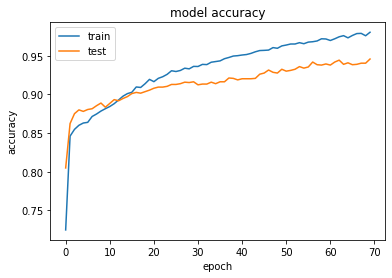

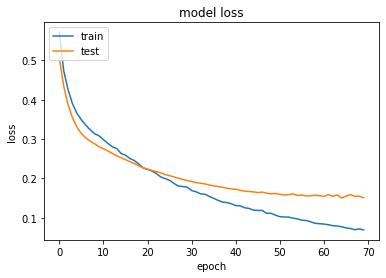

1445/1445 [==============================] - 0s 70us/step
[0.11688692301099275, 0.9474048614501953]
AUC: 0.9866880092605154


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.876817  0.988506   0.494253  0.925016  0.659004  0.549170
1             0.10  0.897578  0.971264   0.541667  0.929377  0.695473  0.594233
2             0.15  0.906574  0.965517   0.565657  0.932011  0.713376  0.616740
3             0.20  0.918339  0.959770   0.600719  0.936219  0.738938  0.649300
4             0.25  0.925952  0.959770   0.625468  0.940546  0.757370  0.672303
5             0.30  0.933564  0.959770   0.652344  0.944873  0.776744  0.696995
6             0.35  0.937716  0.954023   0.669355  0.944753  0.786730  0.711835
7             0.40  0.943945  0.948276   0.696203  0.945814  0.802920  0.735294
8             0.45  0.946021  0.931034   0.710526  0.939553  0.805970  0.745856
9             0.50  0.947405  0.919540   0.720721  0.935380  0.808081  0.753296
10            0.55  0.951557  0.908046   0.745283  0.932780  0.818653  0.772994
11            0.60  0.955017  0.902299  

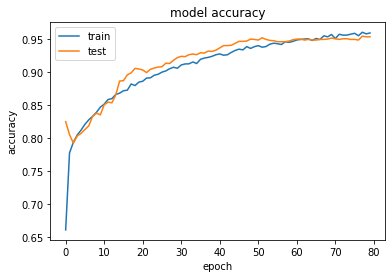

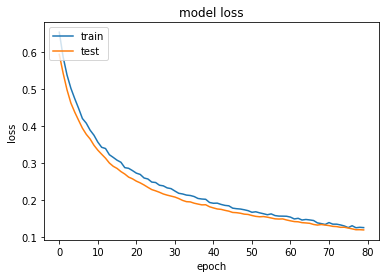

1445/1445 [==============================] - 0s 72us/step
[0.1029286693536699, 0.9619377255439758]
AUC: 0.9908163542147101


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.813841  0.988506   0.391800  0.889217  0.561175  0.445596
1             0.10  0.869896  0.988506   0.480447  0.921082  0.646617  0.535492
2             0.15  0.892042  0.988506   0.527607  0.933671  0.688000  0.581867
3             0.20  0.905882  0.988506   0.562092  0.941538  0.716667  0.615165
4             0.25  0.926644  0.982759   0.624088  0.950860  0.763393  0.673228
5             0.30  0.936332  0.971264   0.660156  0.951407  0.786047  0.705342
6             0.35  0.944637  0.965517   0.694215  0.953648  0.807692  0.735552
7             0.40  0.951557  0.965517   0.724138  0.957582  0.827586  0.762250
8             0.45  0.959170  0.959770   0.762557  0.959429  0.849873  0.795238
9             0.50  0.961938  0.959770   0.776744  0.961002  0.858612  0.807544
10            0.55  0.966090  0.954023   0.801932  0.960882  0.871391  0.828343
11            0.60  0.969550  0.954023  

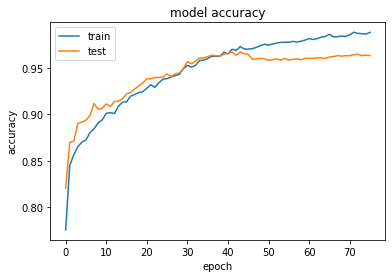

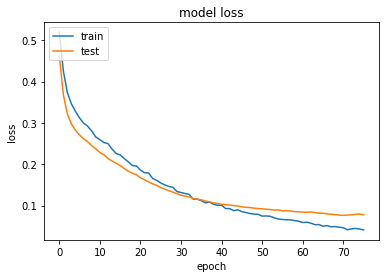

1445/1445 [==============================] - 0s 97us/step
[0.06166574455488306, 0.9757785201072693]
AUC: 0.9963419155882327
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.919723  0.994253   0.600694  0.951886  0.748918  0.652338
1             0.10  0.943945  0.988506   0.685259  0.963175  0.809412  0.730051
2             0.15  0.950865  0.982759   0.715481  0.964629  0.828087  0.756637
3             0.20  0.956401  0.977011   0.742358  0.965296  0.843672  0.779817
4             0.25  0.961246  0.971264   0.768182  0.965569  0.857868  0.801708
5             0.30  0.965398  0.971264   0.789720  0.967930  0.871134  0.820388
6             0.35  0.966782  0.959770   0.802885  0.963756  0.874346  0.830020
7             0.40  0.970934  0.959770   0.826733  0.966116  0.888298  0.850305
8             0.45  0.974394  0.954023   0.851282  0.965603  0.899729  0.870021
9             0.50  0.975779  0.948276   0.863874  0.963910  0.904110  0.879

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
selected_class = 'subclass_IV_2'
y = df_Y_total[selected_class]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
for train_index, test_index in skf.split(np.zeros(y.shape[0]), y):
  print('Start split###########################################################')
  xa_train, xa_test, xd_train, xd_test, y_train, y_test = xa[train_index], xa[test_index], xd[train_index], xd[test_index], y[train_index], y[test_index]

  xa_train, xa_val, xd_train, xd_val, y_train, y_val = train_test_split(xa_train, xd_train, y_train, random_state=10, 
                                                                           test_size=0.2, stratify=y_train)
  from collections import Counter
  print(xa_train.shape, xa_val.shape, xa_test.shape)
  print(xd_train.shape, xd_val.shape, xd_test.shape)
  print(y_train.shape, y_val.shape, y_test.shape)
  print(Counter(y_train), Counter(y_val), Counter(y_test))

  xa_train_resampled, xd_train_resampled, y_train_resampled = resample(xa_train, xd_train, y_train)
  xa_val_resampled, xd_val_resampled, y_val_resampled = resample(xa_val, xd_val, y_val)

  from utils import modeler
  from keras.callbacks import EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  num_epochs = 80
  batch_size = 64

  # Arq7xal
  print('Training Arq7xal model----------------------------------------------------------')
  model = modeler.make_arq7xal_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xa_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xa_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xa_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xa_test)))

  # Arq7xdl
  print('Training Arq7xdl model----------------------------------------------------------')
  model = modeler.make_arq7xdl_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xd_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xd_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xd_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xd_test)))

  print('Training Arq7 model----------------------------------------------------------')
  # Arq7
  model = modeler.make_arq7_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit([xa_train_resampled, xd_train_resampled], y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=([xa_val_resampled, xd_val_resampled],y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate([xa_test,xd_test],y_test))
  print(get_threshold_measures_df(y_test,model.predict([xa_test,xd_test])))

  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Start split###########################################################
(4624, 12, 12, 5) (1156, 12, 12, 5) (1445, 12, 12, 5)
(4624, 20, 15) (1156, 20, 15) (1445, 20, 15)
(4624,) (1156,) (1445,)
Counter({0.0: 3891, 1.0: 733}) Counter({0.0: 973, 1.0: 183}) Counter({0.0: 1216, 1.0: 229})
Correct resample:  True
(7782, 12, 12, 5)
(7782, 20, 15)
Correct resample:  True
(1946, 12, 12, 5)
(1946, 20, 15)
Training Arq7xal model----------------------------------------------------------
Train on 7782 samples, validate on 1946 samples
Epoch 1/80
 - 1s - loss: 0.6990 - accuracy: 0.5438 - val_loss: 0.6296 - val_accuracy: 0.4810
Epoch 2/80
 - 1s - loss: 0.6118 - accuracy: 0.6662 - val_loss: 0.5579 - val_accuracy: 0.7605
Epoch 3/80
 - 1s - loss: 0.5684 - accuracy: 0.7105 - val_loss: 0.5125 - val_accuracy: 0.7590
Epoch 4/80
 - 1s - loss: 0.5337 - accuracy: 0.7397 - val_loss: 0.4795 - val_accuracy: 0.7472
Epoch 5/80
 - 1s - loss: 0.5101 - accuracy: 0.7492 - val_loss: 0.4539 - val_accuracy: 0.7575
Epoch 

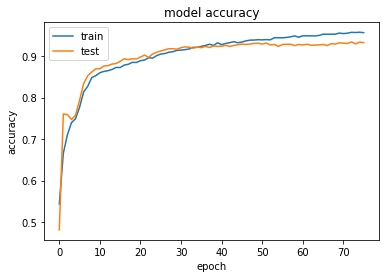

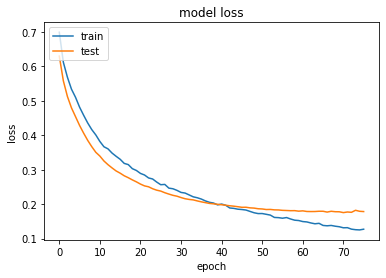

1445/1445 [==============================] - 0s 70us/step
[0.19545314434954453, 0.9280276894569397]
AUC: 0.9750362703976098


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.806920  0.986900   0.450199  0.879963  0.618331  0.505141
1             0.10  0.854671  0.982533   0.522042  0.906562  0.681818  0.576037
2             0.15  0.875433  0.982533   0.561097  0.918898  0.714286  0.613748
3             0.20  0.887889  0.973799   0.588391  0.922755  0.733553  0.638968
4             0.25  0.900346  0.969432   0.618384  0.928384  0.755102  0.666667
5             0.30  0.907958  0.960699   0.639535  0.929363  0.767888  0.685358
6             0.35  0.912803  0.947598   0.655589  0.926924  0.775000  0.698648
7             0.40  0.919031  0.930131   0.678344  0.923536  0.784530  0.717172
8             0.45  0.925260  0.930131   0.698361  0.927237  0.797753  0.734990
9             0.50  0.928028  0.917031   0.711864  0.923565  0.801527  0.745209
10            0.55  0.934948  0.912664   0.738516  0.925904  0.816406  0.767818
11            0.60  0.937716  0.908297  

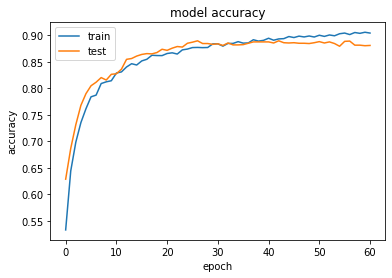

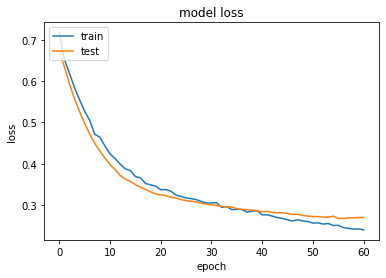

1445/1445 [==============================] - 0s 78us/step
[0.2602482313979868, 0.8920415043830872]
AUC: 0.9556298121121581


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.600692  0.991266   0.283042  0.759202  0.440349  0.330230
1             0.10  0.757785  0.969432   0.392920  0.843680  0.559194  0.445962
2             0.15  0.814533  0.965066   0.459459  0.875625  0.622535  0.513237
3             0.20  0.837370  0.938865   0.493119  0.878561  0.646617  0.544856
4             0.25  0.853979  0.930131   0.522059  0.884885  0.668760  0.572273
5             0.30  0.860900  0.912664   0.535897  0.881908  0.675283  0.584125
6             0.35  0.872664  0.908297   0.560647  0.887125  0.693333  0.607122
7             0.40  0.876817  0.903930   0.570248  0.887820  0.699324  0.615705
8             0.45  0.886505  0.886463   0.595308  0.886488  0.712281  0.637163
9             0.50  0.892042  0.868996   0.612308  0.882689  0.718412  0.650752
10            0.55  0.900346  0.868996   0.635783  0.887623  0.734317  0.671843
11            0.60  0.907958  0.864629  

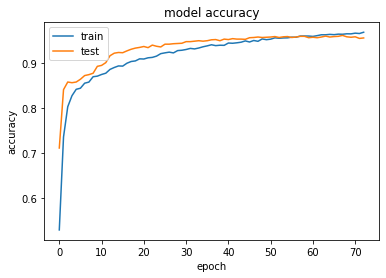

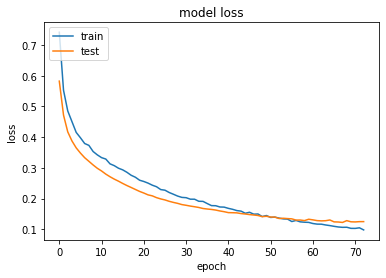

1445/1445 [==============================] - 0s 99us/step
[0.14093721646647964, 0.9577854871749878]
AUC: 0.9851057946449092


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.870588  0.991266   0.550971  0.919564  0.708268  0.604688
1             0.10  0.910035  0.982533   0.641026  0.939457  0.775862  0.688916
2             0.15  0.924567  0.969432   0.685185  0.942775  0.802893  0.727869
3             0.20  0.935640  0.969432   0.720779  0.949354  0.826816  0.759754
4             0.25  0.942561  0.965066   0.746622  0.951694  0.841905  0.782024
5             0.30  0.943945  0.965066   0.751701  0.952516  0.845124  0.786477
6             0.35  0.948789  0.965066   0.770035  0.955395  0.856589  0.802469
7             0.40  0.950865  0.960699   0.780142  0.954856  0.861057  0.810612
8             0.45  0.955709  0.960699   0.800000  0.957734  0.873016  0.827690
9             0.50  0.957785  0.951965   0.813433  0.955423  0.877264  0.837817
10            0.55  0.957093  0.947598   0.812734  0.953240  0.875000  0.836546
11            0.60  0.959170  0.938865  

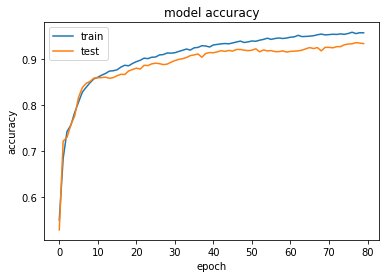

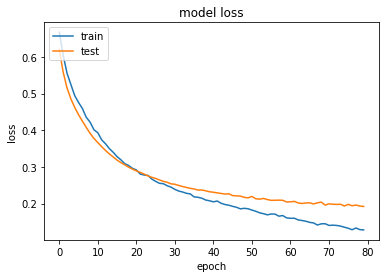

1445/1445 [==============================] - 0s 73us/step
[0.20184923752040237, 0.925259530544281]
AUC: 0.9669831647897036


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.798616  0.978166   0.439216  0.871484  0.606225  0.493610
1             0.10  0.858824  0.960699   0.530120  0.900168  0.683230  0.582319
2             0.15  0.880969  0.956332   0.574803  0.911554  0.718033  0.624643
3             0.20  0.892734  0.943231   0.603352  0.913228  0.735945  0.650211
4             0.25  0.904498  0.938865   0.634218  0.918445  0.757042  0.678233
5             0.30  0.907958  0.908297   0.650000  0.908096  0.757741  0.689198
6             0.35  0.913495  0.908297   0.666667  0.911385  0.768946  0.704130
7             0.40  0.917647  0.908297   0.679739  0.913852  0.777570  0.715760
8             0.45  0.920415  0.899563   0.691275  0.911953  0.781784  0.724842
9             0.50  0.925260  0.890830   0.710801  0.911287  0.790698  0.740741
10            0.55  0.930104  0.882096   0.731884  0.910620  0.800000  0.757689
11            0.60  0.932872  0.864629  

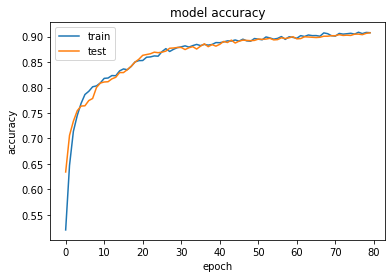

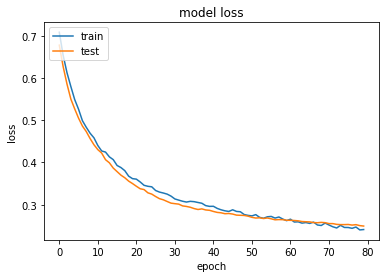

1445/1445 [==============================] - 0s 75us/step
[0.22365332677908834, 0.9141868352890015]
AUC: 0.9649254481728338


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.635294  0.995633   0.302387  0.781534  0.463886  0.351310
1             0.10  0.739792  0.986900   0.377295  0.840078  0.545894  0.430476
2             0.15  0.790311  0.982533   0.429389  0.868322  0.597610  0.483871
3             0.20  0.826298  0.969432   0.476395  0.884387  0.638849  0.530339
4             0.25  0.854671  0.956332   0.522673  0.895929  0.675926  0.574803
5             0.30  0.876817  0.951965   0.566234  0.907315  0.710098  0.616167
6             0.35  0.883737  0.938865   0.582656  0.906110  0.719064  0.630499
7             0.40  0.892734  0.921397   0.606322  0.904366  0.731369  0.650833
8             0.45  0.905190  0.912664   0.641104  0.908223  0.753153  0.681670
9             0.50  0.914187  0.903930   0.669903  0.910024  0.769517  0.706485
10            0.55  0.920415  0.886463   0.695205  0.906636  0.779271  0.726557
11            0.60  0.924567  0.864629  

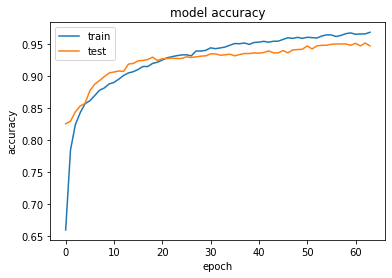

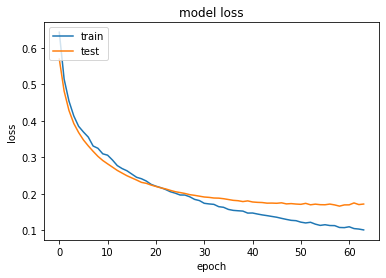

1445/1445 [==============================] - 0s 107us/step
[0.132325418450093, 0.950173020362854]
AUC: 0.984698201562859


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.849827  0.991266   0.513575  0.907229  0.676602  0.568353
1             0.10  0.892042  0.986900   0.596306  0.930539  0.743421  0.647564
2             0.15  0.912111  0.986900   0.645714  0.942463  0.780656  0.693677
3             0.20  0.923183  0.978166   0.678788  0.945497  0.801431  0.723047
4             0.25  0.931488  0.973799   0.705696  0.948659  0.818349  0.746818
5             0.30  0.936332  0.965066   0.724590  0.947993  0.827715  0.762595
6             0.35  0.942561  0.965066   0.746622  0.951694  0.841905  0.782024
7             0.40  0.947405  0.951965   0.770318  0.949256  0.851563  0.800882
8             0.45  0.950865  0.938865   0.790441  0.945995  0.858283  0.816249
9             0.50  0.950173  0.917031   0.798479  0.936723  0.853659  0.819672
10            0.55  0.952941  0.917031   0.810811  0.938367  0.860656  0.830040
11            0.60  0.955017  0.912664  

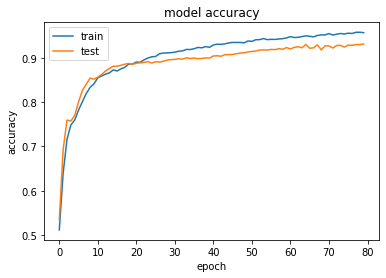

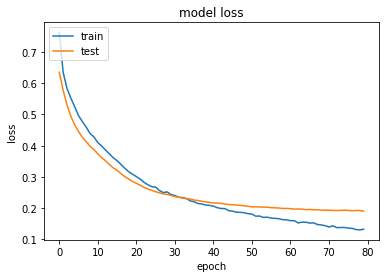

1445/1445 [==============================] - 0s 70us/step
[0.15903938424912084, 0.9418684840202332]
AUC: 0.9807838715237877


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.808997  0.991266   0.453094  0.882969  0.621918  0.508285
1             0.10  0.871972  0.986900   0.553922  0.918614  0.709576  0.607200
2             0.15  0.899654  0.982533   0.614754  0.933289  0.756303  0.664501
3             0.20  0.912111  0.973799   0.648256  0.937146  0.778360  0.694704
4             0.25  0.921799  0.960699   0.679012  0.937586  0.795660  0.721311
5             0.30  0.930104  0.956332   0.706452  0.940748  0.812616  0.745405
6             0.35  0.932872  0.947598   0.718543  0.938848  0.817326  0.755045
7             0.40  0.939792  0.943231   0.744828  0.941188  0.832370  0.777538
8             0.45  0.942561  0.938865   0.757042  0.941061  0.838207  0.787546
9             0.50  0.941869  0.925764   0.759857  0.935333  0.834646  0.788104
10            0.55  0.944637  0.908297   0.779026  0.929889  0.838710  0.801850
11            0.60  0.950173  0.903930  

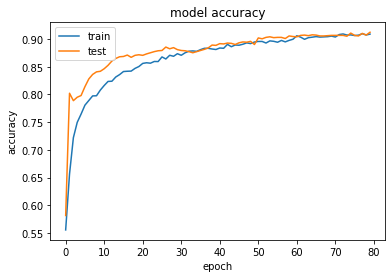

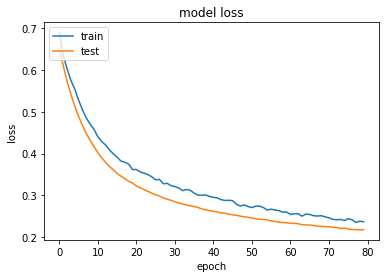

1445/1445 [==============================] - 0s 78us/step
[0.2113244779227514, 0.9231833815574646]
AUC: 0.9693676740979085


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.703806  0.991266   0.347626  0.820469  0.514739  0.399507
1             0.10  0.782007  0.986900   0.420074  0.865160  0.589309  0.474591
2             0.15  0.838754  0.973799   0.495556  0.893561  0.656848  0.549532
3             0.20  0.862284  0.969432   0.536232  0.905769  0.690513  0.588859
4             0.25  0.880969  0.965066   0.574026  0.915099  0.719870  0.624647
5             0.30  0.893426  0.960699   0.602740  0.920728  0.740741  0.651273
6             0.35  0.901038  0.960699   0.621469  0.925251  0.754717  0.668693
7             0.40  0.903806  0.943231   0.631579  0.919807  0.756567  0.676268
8             0.45  0.912111  0.934498   0.656442  0.921196  0.771171  0.697978
9             0.50  0.923183  0.930131   0.691558  0.926003  0.793296  0.728953
10            0.55  0.925952  0.917031   0.704698  0.922331  0.796964  0.738916
11            0.60  0.929412  0.917031  

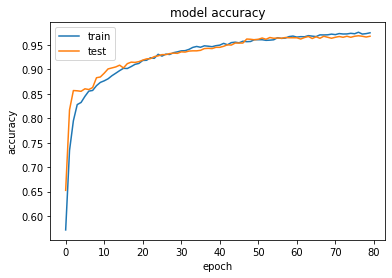

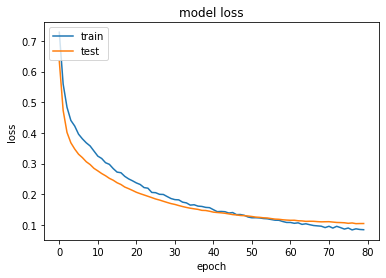

1445/1445 [==============================] - 0s 111us/step
[0.09165258560278114, 0.9730103611946106]
AUC: 0.9920420592967134


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.896194  0.995633   0.604775  0.936550  0.752475  0.656304
1             0.10  0.930796  0.991266   0.698462  0.955337  0.819495  0.742315
2             0.15  0.943945  0.982533   0.745033  0.959605  0.847458  0.782881
3             0.20  0.954325  0.982533   0.783972  0.965773  0.872093  0.816993
4             0.25  0.961246  0.982533   0.812274  0.969885  0.889328  0.841436
5             0.30  0.962630  0.978166   0.820513  0.968935  0.892430  0.847843
6             0.35  0.963322  0.969432   0.828358  0.965802  0.893360  0.853190
7             0.40  0.968858  0.956332   0.862205  0.963774  0.906832  0.879518
8             0.45  0.970934  0.947598   0.878543  0.961464  0.911765  0.891537
9             0.50  0.973010  0.947598   0.889344  0.962697  0.917548  0.900415
10            0.55  0.973702  0.943231   0.896266  0.961336  0.919149  0.905281
11            0.60  0.976471  0.938865  

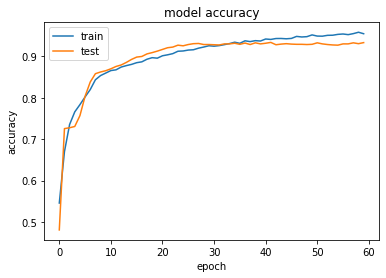

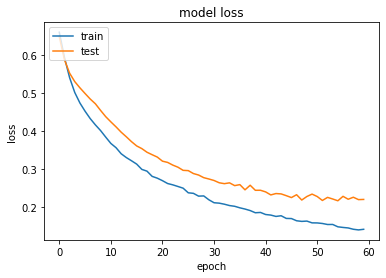

1445/1445 [==============================] - 0s 67us/step
[0.2126255432627193, 0.9162629842758179]
AUC: 0.9732065904389795


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.723183  0.991266   0.363200  0.831982  0.531616  0.415903
1             0.10  0.821453  0.991266   0.469979  0.890370  0.637640  0.525220
2             0.15  0.855363  0.991266   0.523041  0.910518  0.684766  0.577608
3             0.20  0.871280  0.982533   0.552826  0.916431  0.707547  0.605816
4             0.25  0.883045  0.965066   0.578534  0.916332  0.723404  0.628913
5             0.30  0.889965  0.960699   0.594595  0.918672  0.734558  0.643651
6             0.35  0.899654  0.951965   0.619318  0.920884  0.750430  0.665852
7             0.40  0.907266  0.951965   0.639296  0.925407  0.764912  0.684244
8             0.45  0.912111  0.943231   0.654545  0.924741  0.772809  0.697224
9             0.50  0.916263  0.934498   0.668750  0.923663  0.779599  0.709079
10            0.55  0.919723  0.925764   0.681672  0.922175  0.785185  0.719620
11            0.60  0.925952  0.903930  

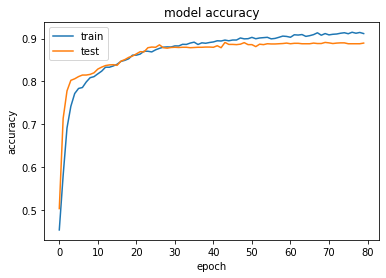

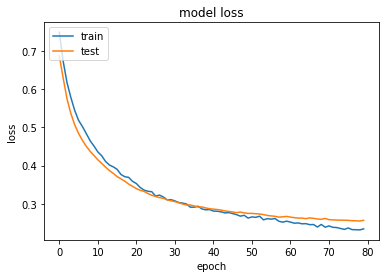

1445/1445 [==============================] - 0s 80us/step
[0.2353419178909909, 0.903806209564209]
AUC: 0.9600702424729947


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.633910  0.982533   0.300000  0.775395  0.459653  0.348405
1             0.10  0.783391  0.956332   0.419540  0.853577  0.583222  0.472594
2             0.15  0.824913  0.951965   0.473913  0.876476  0.632801  0.526825
3             0.20  0.851211  0.951965   0.516588  0.892101  0.669739  0.568597
4             0.25  0.870588  0.951965   0.553299  0.903614  0.699839  0.603878
5             0.30  0.877509  0.938865   0.568783  0.902409  0.708402  0.617461
6             0.35  0.887197  0.925764   0.592179  0.902849  0.722317  0.638170
7             0.40  0.894118  0.912664   0.611111  0.901644  0.732049  0.654352
8             0.45  0.899654  0.899563   0.628049  0.899617  0.739677  0.668397
9             0.50  0.903806  0.886463   0.642405  0.896768  0.744954  0.679839
10            0.55  0.910727  0.873362   0.666667  0.895563  0.756144  0.699790
11            0.60  0.920415  0.860262  

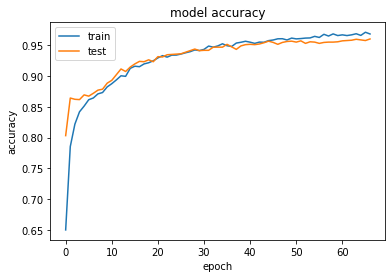

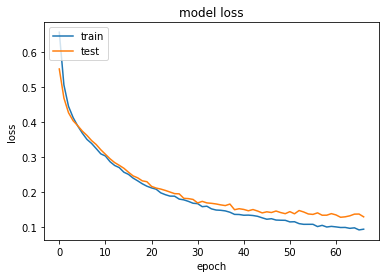

1445/1445 [==============================] - 0s 105us/step
[0.13261307840941275, 0.9508650302886963]
AUC: 0.9860017811997243


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  

    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.851211  0.991266   0.515909  0.908051  0.678625  0.570639
1             0.10  0.894118  0.986900   0.601064  0.931772  0.747107  0.652048
2             0.15  0.914879  0.986900   0.653179  0.944108  0.786087  0.700558
3             0.20  0.925952  0.973799   0.688272  0.945370  0.806510  0.731148
4             0.25  0.935640  0.973799   0.719355  0.951127  0.827458  0.759020
5             0.30  0.939100  0.969432   0.732673  0.951410  0.834586  0.770298
6             0.35  0.943253  0.951965   0.754325  0.946788  0.841699  0.787004
7             0.40  0.948097  0.943231   0.776978  0.946122  0.852071  0.805369
8             0.45  0.948789  0.925764   0.788104  0.939445  0.851406  0.812261
9             0.50  0.950865  0.925764   0.796992  0.940678  0.856566  0.819799
10            0.55  0.955017  0.921397   0.817829  0.941373  0.866530  0.836638
11            0.60  0.956401  0.917031  

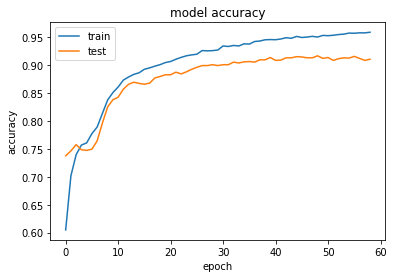

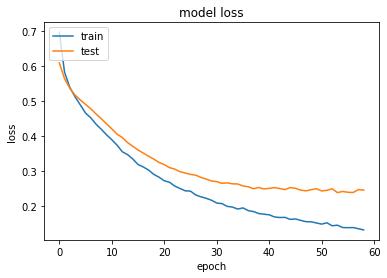

1445/1445 [==============================] - 0s 68us/step
[0.2151760052083943, 0.9148789048194885]
AUC: 0.9761531113537117


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.760554  1.000000   0.398261  0.857730  0.569652  0.452748
1             0.10  0.831142  1.000000   0.484144  0.899671  0.652422  0.539840
2             0.15  0.858131  0.982533   0.528169  0.908618  0.687023  0.581997
3             0.20  0.873356  0.978166   0.557214  0.915892  0.709984  0.609690
4             0.25  0.891349  0.978166   0.595745  0.926583  0.740496  0.646278
5             0.30  0.903806  0.978166   0.625698  0.933984  0.763203  0.674293
6             0.35  0.907266  0.973799   0.635328  0.934268  0.768966  0.682792
7             0.40  0.914187  0.965066   0.655786  0.934835  0.780919  0.700698
8             0.45  0.915571  0.956332   0.661631  0.932113  0.782143  0.705087
9             0.50  0.914879  0.947598   0.661585  0.928158  0.779174  0.704088
10            0.55  0.919031  0.938865   0.676101  0.927080  0.786106  0.716189
11            0.60  0.924567  0.934498  

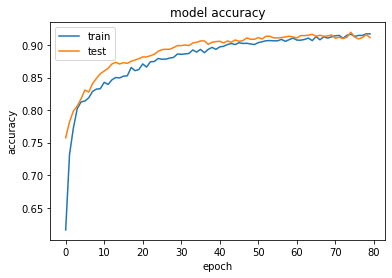

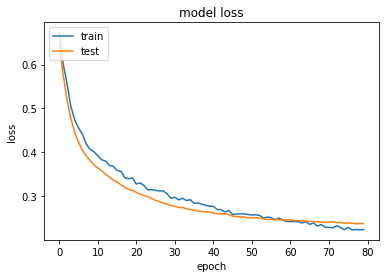

1445/1445 [==============================] - 0s 68us/step
[0.23580338657933536, 0.9100345969200134]
AUC: 0.9533853568145254


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.689273  0.969432   0.334337  0.802973  0.497200  0.384749
1             0.10  0.789619  0.947598   0.426326  0.853733  0.588076  0.479029
2             0.15  0.832526  0.943231   0.485393  0.877455  0.640950  0.537581
3             0.20  0.853287  0.943231   0.520482  0.889790  0.670807  0.571731
4             0.25  0.860208  0.934498   0.533666  0.890357  0.679365  0.583742
5             0.30  0.876125  0.925764   0.566845  0.896270  0.703151  0.614493
6             0.35  0.887889  0.912664   0.595442  0.897944  0.720690  0.639927
7             0.40  0.895502  0.908297   0.615385  0.900695  0.733686  0.657812
8             0.45  0.903806  0.890830   0.641509  0.898540  0.745887  0.679547
9             0.50  0.910035  0.873362   0.664452  0.895152  0.754717  0.697837
10            0.55  0.915571  0.864629   0.685121  0.894897  0.764479  0.714801
11            0.60  0.923875  0.855895  

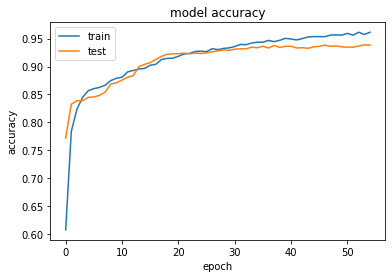

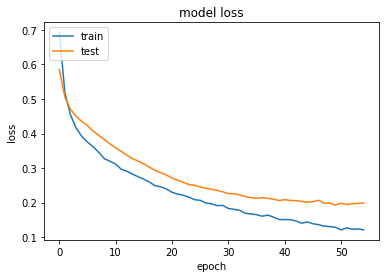

1445/1445 [==============================] - 0s 98us/step
[0.15077558549630188, 0.9487889409065247]
AUC: 0.9838955843484256
    Punto de corte  Accuracy    Recall  Precision       AUC        F1      F0.5
0             0.05  0.788235  0.991266   0.427495  0.870633  0.597368  0.482363
1             0.10  0.867128  0.978166   0.545012  0.912192  0.700000  0.597971
2             0.15  0.901038  0.978166   0.618785  0.932340  0.758037  0.667859
3             0.20  0.911419  0.960699   0.648968  0.931418  0.774648  0.694006
4             0.25  0.921107  0.960699   0.676923  0.937175  0.794224  0.719424
5             0.30  0.933564  0.956332   0.718033  0.942804  0.820225  0.755694
6             0.35  0.937716  0.956332   0.732441  0.945271  0.829545  0.768421
7             0.40  0.941176  0.956332   0.744898  0.947327  0.837476  0.779359
8             0.45  0.946021  0.956332   0.763066  0.950205  0.848837  0.795207
9             0.50  0.948789  0.956332   0.773852  0.951850  0.855469  0.804

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
selected_class = 'subclass_IV_4'
y = df_Y_total[selected_class]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
for train_index, test_index in skf.split(np.zeros(y.shape[0]), y):
  print('Start split###########################################################')
  xa_train, xa_test, xd_train, xd_test, y_train, y_test = xa[train_index], xa[test_index], xd[train_index], xd[test_index], y[train_index], y[test_index]

  xa_train, xa_val, xd_train, xd_val, y_train, y_val = train_test_split(xa_train, xd_train, y_train, random_state=10, 
                                                                           test_size=0.2, stratify=y_train)
  from collections import Counter
  print(xa_train.shape, xa_val.shape, xa_test.shape)
  print(xd_train.shape, xd_val.shape, xd_test.shape)
  print(y_train.shape, y_val.shape, y_test.shape)
  print(Counter(y_train), Counter(y_val), Counter(y_test))

  xa_train_resampled, xd_train_resampled, y_train_resampled = resample(xa_train, xd_train, y_train)
  xa_val_resampled, xd_val_resampled, y_val_resampled = resample(xa_val, xd_val, y_val)

  from utils import modeler
  from keras.callbacks import EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  num_epochs = 80
  batch_size = 64

  # Arq7xal
  print('Training Arq7xal model----------------------------------------------------------')
  model = modeler.make_arq7xal_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xa_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xa_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xa_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xa_test)))

  # Arq7xdl
  print('Training Arq7xdl model----------------------------------------------------------')
  model = modeler.make_arq7xdl_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit(xd_train_resampled, y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=(xd_val_resampled,y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate(xd_test,y_test))
  print(get_threshold_measures_df(y_test,model.predict(xd_test)))

  print('Training Arq7 model----------------------------------------------------------')
  # Arq7
  model = modeler.make_arq7_model(selected_class)
  model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=["accuracy"])

  history = model.fit([xa_train_resampled, xd_train_resampled], y_train_resampled, 
                      shuffle=True, batch_size=batch_size, epochs=num_epochs, verbose=2, 
                      validation_data=([xa_val_resampled, xd_val_resampled],y_val_resampled),
                     callbacks=[es])
  
  plot_train_history(history)

  print(model.evaluate([xa_test,xd_test],y_test))
  print(get_threshold_measures_df(y_test,model.predict([xa_test,xd_test])))

  